In [25]:
%pip install -q --proxy http://proxy:80 statsmodels

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
######## Search space #########
import sys
sys.path.append("../")
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results
# Initialize an empty list to store dictionaries
def results_to_df(path, name):
    data = []
    # Open the text file
    with open(path, 'r') as file:
        lines = file.readlines()
        # Initialize an empty dictionary to store data for each block
        block_data = {}
        for line in lines:
            # If the line contains dashes, it indicates the end of a block
            if '-------------------------' in line:
                # If block_data is not empty, add it to the list of data dictionaries
                if block_data:
                    data.append(block_data)
                    # Reset block_data for the next block
                    block_data = {}
            elif 'best_acc' in line:
                continue
            else:
                # Split the line by ':'
                #print(line)
                key, value = line.strip().split(': ')
                # Store the key-value pair in the block_data dictionary
                block_data[key] = value

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    # Convert columns to appropriate data types if needed
    df['epoch'] = df['epoch'].astype(int)
    df['lr'] = df['lr'].astype(float)
    df['train_acc'] = df['train_acc'].astype(float)
    df['train_loss'] = df['train_loss'].astype(float)
    df['test_acc'] = df['test_acc'].astype(float)
    df['test_acc_top5'] = df['test_acc_top5'].astype(float)
    df['test_loss'] = df['test_loss'].astype(float)
    df['epoch_time'] = df['epoch_time'].astype(float)
    df=df.assign(name=name)
    
    return df
def percentage_of_elements_in_list(list1, list2):
    # Count the number of elements in list1 that are also in list2
    common_elements_count = sum(1 for element in list1 if element in list2)
    # Calculate the percentage
    percentage = (common_elements_count / len(list1)) * 100
    return percentage


import os
def get_vainilla_dfs(folder, epochs, corr=False):
    students=os.listdir(folder)
    print(students)
    sudents=[student for student in students if "ipynb_checkpoints" not in student]
    students_df=[]
    for student in students:
        try:
            students_df.append(results_to_df(f"{folder}/{student}/worklog.txt", student))
        except:
            pass
    students_df=pd.concat(students_df, ignore_index=True)
    students_df=students_df.sort_values(by=["epoch","test_acc"], ascending=[False,False])
    students_df=students_df.assign(study="vainilla")
    
    idx = students_df.groupby("name")["test_acc"].idxmax()
    #idx = students_df.groupby("name")["epoch"].idxmax()
    max_test_acc_rows = students_df.loc[idx]
    sorted_df=max_test_acc_rows.sort_values(by="test_acc")
    sorted_df=sorted_df.rename(columns={"test_acc":"best_acc"})
    order_students=list(sorted_df.name.values)

    vainilla_students=[]
    students_df["name"] = pd.Categorical(students_df["name"], categories=order_students, ordered=True)
    for i in range(1,epochs+1):
        vainilla_students.append(students_df[students_df.epoch==i].sort_values(by="name")) 
    
    corr_coeff_vainilla=[]
    if corr:
        for epoch in vainilla_students:
            correlation_coefficient =np.corrcoef(list(epoch['test_acc'].values),list(sorted_df['best_acc'].values))
            corr_coeff_vainilla.append(correlation_coefficient[0,1])
    return order_students, sorted_df, vainilla_students, corr_coeff_vainilla


def get_students_dfs(folder, epochs,sorted_df,order_students,study, corr=False, corr_n=20):
    students_list=os.listdir(folder)
    students_kd=[student for student in students_list if os.path.isdir(f"{folder}/{student}")]
    students_kd_df=[]

    for student in students_kd:
        students_kd_df.append(results_to_df(f"{folder}/{student}/worklog.txt", student))
    students_kd_df=pd.concat(students_kd_df, ignore_index=True)
    students_kd_df=students_kd_df.sort_values(by=["epoch","test_acc"], ascending=[False,False])
    students_kd_df=students_kd_df.assign(study=study)
    
    #students_kd_df['name']=students_kd_df['name'].str.split('_').str[1:3].str.join('_')

    kd_students=[]
    students_kd_df["name"] = pd.Categorical(students_kd_df["name"], categories=order_students, ordered=True)
    for i in range(1,epochs+1):
        kd_students.append(students_kd_df[students_kd_df.epoch==i].sort_values(by="name")) 

    corr_coeff_kd=[]
    if corr==True:
        for epoch in kd_students:
            correlation_coefficient =np.corrcoef(list(epoch['test_acc'].values[:corr_n]),list(sorted_df['best_acc'].values[:corr_n]))
            corr_coeff_kd.append(correlation_coefficient[0,1])    
    return kd_students, corr_coeff_kd

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [133]:
metadata={"num_classes": 4, "input_shape": [49260, 3, 64, 64], "codename": "Caitie", "benchmark":47.008}
regnet_space=RegNet(metadata,
                    W0=[8, 56, 8],
                    WA=[8, 48, 8],
                    WM=[2.0,2.9,0.05],
                    D=[6,20,1], 
                    G=[8,8,8], 
                    base_config="../configs/search_space/config.yaml")

In [155]:
#WA,W0,WM,DEPTH=48,24,2.4,12
test_folder="tests_one_model"
generation=1
#config_updates=["REGNET.STEM_W",32, "MODEL.NUM_CLASSES",20]
config_updates=None
models, chromosomes=regnet_space.load_generation(folder=f"{test_folder}/Generation_{generation}_SE", config_updates=config_updates)


res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'stem_type': 'res_stem_cifar', 'stem_w': 32, 'block_type': 'res_bottleneck_block', 'depths': [1, 1, 3, 4, 9, 2], 'widths': [8, 72, 144, 288, 592, 1216], 'strides': [2, 2, 2, 2, 2, 2], 'bot_muls': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'group_ws': [8, 8, 8, 8, 8, 8], 'head_w': 0, 'se_r': 0.25, 'num_classes': 20, 'downsample': 'avg', 'drop_path_rate': 0.0}
Loading model: tests_one_model/Generation_1_SE/olive_wasp/config.yaml
res_bottleneck_block
res

In [9]:
chromosomes[list(chromosomes.keys())[0]]

{'ws': [24, 48, 96, 192, 384, 768],
 'bs': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'gs': [8, 8, 8, 8, 8, 8],
 'ds': [1, 1, 1, 4, 6, 5],
 'num_stages': 6,
 'total_size_mb': 39.516258239746094,
 'h': 1,
 'w': 1,
 'flops': 1812518,
 'params': 10358950,
 'acts': 8678,
 'WA': 40.0,
 'W0': 24,
 'WM': 2.0,
 'DEPTH': 18,
 'GROUP_W': 8}

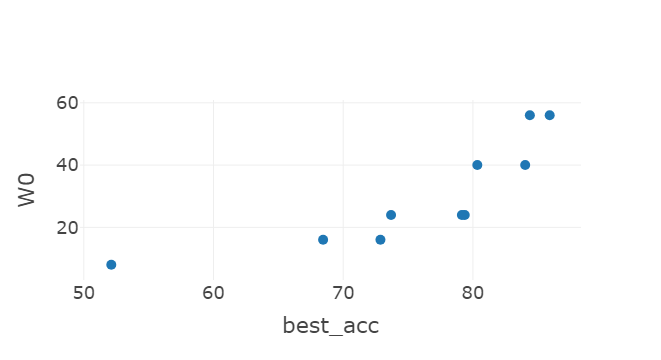

In [21]:
scatter_results(chromosomes,  "W0","best_acc","tests_one_model/Generation_1_NOSE_D/results.csv")

# AddNIST results

In [17]:
#sorted_df["NOSE_D"].to_csv("tests_one_model/Generation_1_NOSE_D/results.csv")

In [23]:
folders=["tests_one_model/Generation_1_SE","tests_one_model/Generation_1_SE_D","tests_one_model/Generation_1_NOSE_D","tests_one_model/Generation_1_NOSE_NOD","tests_one_model/Generation_1_NOSE_D_DropPath"]
sorted_df={}
corr_coeff_vainilla={}
vainilla_students={}
order_students={}
for folder in folders:
    name=f"{folder.split("/")[1][13:]}"
    order_students[name], sorted_df[name], vainilla_students[name], corr_coeff=get_vainilla_dfs(folder, 20, True)
    sorted_df[name]["study"]=name
    sorted_df[name]= sorted_df[name].reset_index().reset_index()
    corr_coeff_vainilla[name]=pd.DataFrame(corr_coeff).reset_index()
    corr_coeff_vainilla[name]["study"]=name

['olive_wasp', 'hospitable_pronghorn', 'spectral_hare', 'loyal_tiger', 'astute_badger', 'quizzical_caiman', 'zircon_toad', 'hypersonic_sambar', 'honest_saluki', 'neat_puffin']
['olive_wasp', 'hospitable_pronghorn', 'spectral_hare', 'loyal_tiger', 'astute_badger', 'quizzical_caiman', 'zircon_toad', 'hypersonic_sambar', 'honest_saluki', 'neat_puffin']
['olive_wasp', 'hospitable_pronghorn', 'spectral_hare', 'loyal_tiger', 'astute_badger', 'quizzical_caiman', 'zircon_toad', 'hypersonic_sambar', 'honest_saluki', 'results.csv', 'neat_puffin']
['olive_wasp', 'hospitable_pronghorn', 'spectral_hare', 'loyal_tiger', 'astute_badger', 'quizzical_caiman', 'zircon_toad', 'hypersonic_sambar', 'honest_saluki', 'neat_puffin']
['olive_wasp', 'hospitable_pronghorn', 'spectral_hare', '.ipynb_checkpoints', 'loyal_tiger', 'astute_badger', 'quizzical_caiman', 'zircon_toad', 'hypersonic_sambar', 'honest_saluki', 'neat_puffin']


In [4]:
sorted_df.keys()

dict_keys(['SE', 'SE_D', 'NOSE_D', 'NOSE_NOD', 'NOSE_D_DropPath'])

In [38]:
kd_students, corr_coeff_kd=get_students_dfs("tests_one_model/Generation_1_SE_D_warmup_labels01_s1", 2, sorted_df["SE_D"],order_students["SE_D"], "SE_D_label", corr=True, corr_n=20)

In [39]:
corr_coeff_kd

[0.9141923219017162, 0.7565509799604345]

In [31]:
corr_coeff_kd

[0.9141923219017162, 0.7565509799604345]

In [3]:
ep=0
scatter_df=pd.concat([sorted_df["SE"],sorted_df["SE_D"],sorted_df["NOSE_D"],sorted_df["NOSE_NOD"],sorted_df["NOSE_D_DropPath"]])
#scatter_df=pd.merge(scatter_df, sorted_df[["name","best_acc"]], on="name")

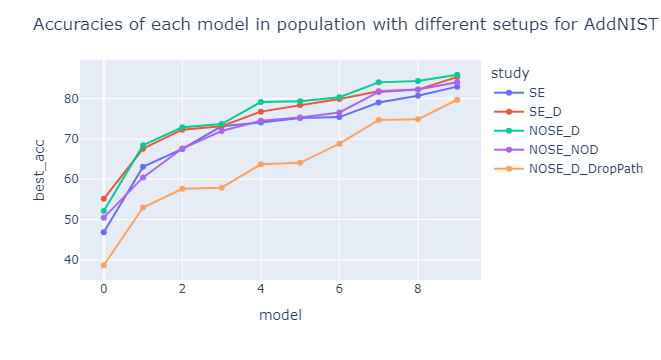

In [11]:
import plotly.express as px

fig = px.line(scatter_df,x="level_0", y="best_acc",color='study', markers=True)
#fig.add_scatter(x=x, y=y_std, mode='markers', name='Data2',trendline="ols", marker=dict(color='green'))
fig.update_layout(height=700)
fig.update_layout(xaxis_title='model', title="Accuracies of each model in population with different setups for AddNIST dataset")
fig.show()

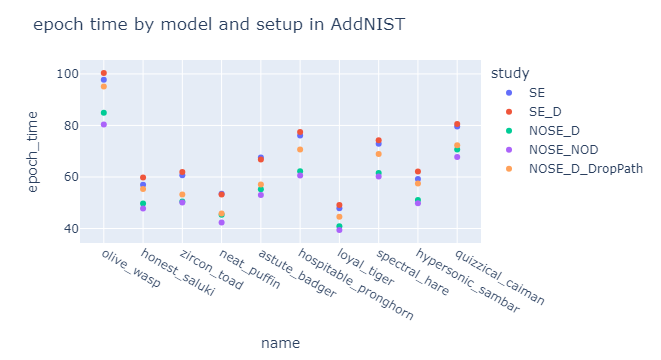

In [14]:
import plotly.express as px

fig = px.scatter(scatter_df,x="name", y="epoch_time",color='study')
#fig.add_scatter(x=x, y=y_std, mode='markers', name='Data2',trendline="ols", marker=dict(color='green'))
fig.update_layout(height=500, title="epoch time by model and setup in AddNIST")
fig.show()

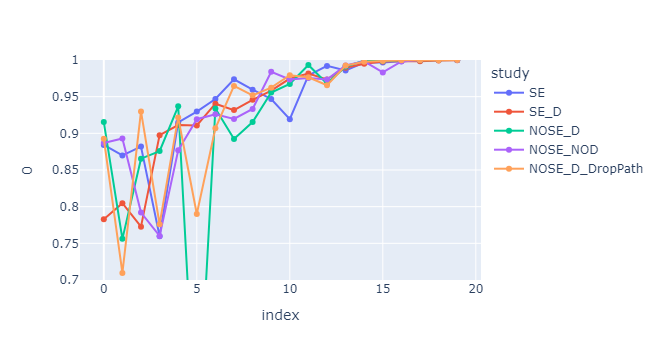

In [31]:
import plotly.express as px
scatter_df=pd.concat([corr_coeff_vainilla["SE"],corr_coeff_vainilla["SE_D"],corr_coeff_vainilla["NOSE_D"],corr_coeff_vainilla["NOSE_NOD"], corr_coeff_vainilla["NOSE_D_DropPath"]])
fig = px.line(scatter_df,x="index", y=0,color='study', markers=True)
#fig.add_scatter(x=x, y=y_std, mode='markers', name='Data2',trendline="ols", marker=dict(color='green'))
fig.update_layout(height=800)
fig.update_yaxes(range=[0.7, 1]) 
fig.show()

In [47]:
sorted_df["NOSE_D"]

level_0  index  epoch        lr  train_acc  train_loss  best_acc  \
0        0     19     20  0.000062      50.28        1.50     52.12   
1        1    179     20  0.000062      66.92        1.04     68.45   
2        2    139     20  0.000062      72.22        0.88     72.87   
3        3    199     20  0.000062      72.65        0.87     73.69   
4        4     99     20  0.000062      79.15        0.66     79.15   
5        5     79     20  0.000062      78.70        0.68     79.37   
6        6     39     20  0.000062      81.00        0.61     80.34   
7        7    159     20  0.000062      85.35        0.47     84.03   
8        8     59     20  0.000062      85.62        0.46     84.39   
9        9    119     20  0.000062      87.78        0.39     85.92   

   test_acc_top5  test_loss  epoch_time                  name   study  
0          87.22       1.48       84.96            olive_wasp  NOSE_D  
1          94.04       1.01       49.73         honest_saluki  NOSE_D  
2          95.31       0.86       50.45           zircon_toad  NOSE_D  
3          95.42       0.84       45.29           neat_puffin  NOSE_D  
4          96.95       0.68       55.19         astute_badger  NOSE_D  
5          96.85       0.68       40.92           loyal_tiger  NOSE_D  
6          97.11       0.64       62.21  hospitable_pronghorn  NOSE_D  
7          97.83       0.53       51.02     hypersonic_sambar  NOSE_D  
8          97.95       0.52       61.56         spectral_hare  NOSE_D  
9          98.35       0.47       70.71      quizzical_caiman  NOSE_D

# CIFARTile

In [176]:
#WA,W0,WM,DEPTH=48,24,2.4,12
test_folder="tests_cifar_tile"
generation=1
#config_updates=["REGNET.STEM_W",32, "MODEL.NUM_CLASSES",20]
config_updates=None
models, chromosomes=regnet_space.load_generation(folder=f"{test_folder}/Generation_{generation}", config_updates=config_updates)


res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 16, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 16, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 16, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 16, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'stem_type': 'res_stem_cifar', 'stem_w': 28, 'block_type': 'res_bottleneck_block', 'depths': [1, 4, 6, 8], 'widths': [32, 64, 144, 288], 'strides': [2, 2, 2, 2], 'bot_muls': [1.0, 1.0, 1.0, 1.0], 'group_ws': [16, 16, 16, 16], 'head_w': 0, 'se_r': 0.25, 'num_classes': 20, 'downsample': 'avg', 'drop_path_rate': 0.0}
Loading model: tests_filtered_regnet/Generation_1/steel_rook/config.yaml
res_bottleneck_block
res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 16, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 16, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0}
{'stem_

In [18]:
folders=["tests_cifar_tile/Generation_1_SE_D", "tests_cifar_tile/Generation_1_SE_NOD", "tests_cifar_tile/Generation_1_NOSE_D", "tests_cifar_tile/Generation_1_SE_D_s42_warmup","tests_cifar_tile/Generation_1_SE_D_lr001_s1","tests_cifar_tile/Generation_1_SE_D_s1_warmup_labels01"]
sorted_df={}
corr_coeff_vainilla={}
vainilla_students={}
order_students={}
for folder in folders:
    name=f"{folder.split("/")[1][13:]}"
    try:
        order_students[name], sorted_df[name], vainilla_students[name], corr_coeff=get_vainilla_dfs(folder, 20, True)
    except:
        order_students[name], sorted_df[name], vainilla_students[name], corr_coeff=get_vainilla_dfs(folder, 2, True)
    sorted_df[name]["study"]=name
    sorted_df[name]= sorted_df[name].reset_index().reset_index()
    corr_coeff_vainilla[name]=pd.DataFrame(corr_coeff).reset_index()
    corr_coeff_vainilla[name]["study"]=name

['wakeful_mongoose', 'didactic_zebu', 'lime_vulture', 'enormous_limpet', 'happy_raven', 'unselfish_ermine', 'dynamic_wasp', 'heavenly_squirrel', 'angelic_lizard', 'loutish_tiger', 'flying_capuchin', 'ultra_herring', 'whimsical_lemming', 'poetic_poodle', 'umber_binturong', 'magic_sidewinder', 'results.csv', 'agile_barracuda', 'invaluable_cormorant', 'optimal_elk', 'phenomenal_dragon']
['wakeful_mongoose', 'didactic_zebu', 'lime_vulture', 'enormous_limpet', 'happy_raven', 'unselfish_ermine', 'dynamic_wasp', 'heavenly_squirrel', 'angelic_lizard', 'loutish_tiger', 'flying_capuchin', 'ultra_herring', 'whimsical_lemming', 'poetic_poodle', 'umber_binturong', 'magic_sidewinder', 'agile_barracuda', 'invaluable_cormorant', 'optimal_elk', 'phenomenal_dragon']
['wakeful_mongoose', 'didactic_zebu', 'lime_vulture', 'enormous_limpet', 'happy_raven', 'unselfish_ermine', 'dynamic_wasp', 'heavenly_squirrel', 'angelic_lizard', 'loutish_tiger', 'flying_capuchin', 'ultra_herring', 'whimsical_lemming', 'poe

In [10]:
sorted_df["SE_D"]

level_0  index  epoch        lr  train_acc  train_loss  best_acc  \
0         0     18     19  0.000245      34.12        1.33     34.36   
1         1    198     19  0.000245      46.03        1.13     46.64   
2         2    158     19  0.000245      47.68        1.11     47.38   
3         3     37     18  0.000545      48.02        1.10     47.71   
4         4    219     20  0.000062      47.29        1.12     47.76   
5         5    139     20  0.000062      48.78        1.09     48.25   
6         6    319     20  0.000062      49.48        1.08     48.27   
7         7     78     19  0.000245      50.59        1.05     49.62   
8         8     98     19  0.000245      50.80        1.06     50.11   
9         9    398     19  0.000245      51.16        1.05     50.45   
10       10    339     20  0.000062      51.77        1.03     50.92   
11       11    358     19  0.000245      52.37        1.02     51.29   
12       12    297     18  0.000545      51.28        1.04     51.55   
13       13    379     20  0.000062      52.73        1.02     51.90   
14       14    257     18  0.000545      52.38        1.03     52.37   
15       15    118     19  0.000245      56.76        0.95     52.51   
16       16     58     19  0.000245      52.74        1.02     52.57   
17       17    178     19  0.000245      53.73        1.00     52.81   
18       18    279     20  0.000062      52.84        1.02     52.81   
19       19    238     19  0.000245      54.86        0.98     52.98   

    test_acc_top5  test_loss  epoch_time                  name study  
0           60.33       1.36       99.20      wakeful_mongoose  SE_D  
1           74.61       1.13       57.74         loutish_tiger  SE_D  
2           75.10       1.23       97.15     heavenly_squirrel  SE_D  
3           75.91       1.11       58.32         didactic_zebu  SE_D  
4           75.88       1.11       79.02       flying_capuchin  SE_D  
5           76.26       1.11       87.65          dynamic_wasp  SE_D  
6           75.87       1.19      108.61      magic_sidewinder  SE_D  
7           77.84       1.07       89.99       enormous_limpet  SE_D  
8           77.89       1.58      114.49           happy_raven  SE_D  
9           78.41       1.07       59.70     phenomenal_dragon  SE_D  
10          78.77       1.06      148.25       agile_barracuda  SE_D  
11          78.89       1.47      130.76  invaluable_cormorant  SE_D  
12          79.06       1.06       97.41       umber_binturong  SE_D  
13          79.75       1.04       66.56           optimal_elk  SE_D  
14          79.72       1.04       78.08     whimsical_lemming  SE_D  
15          79.69       1.75      124.92      unselfish_ermine  SE_D  
16          79.88       1.03      102.76          lime_vulture  SE_D  
17          80.63       1.02       70.45        angelic_lizard  SE_D  
18          80.14       1.03       85.15         poetic_poodle  SE_D  
19          80.36       1.15      115.71         ultra_herring  SE_D

In [53]:
vainilla_students["SE_D"][0].sort_values("test_acc")

epoch    lr  train_acc  train_loss  test_acc  test_acc_top5  test_loss  \
320      1  0.01      25.05        1.43     24.75          50.21       1.40   
120      1  0.01      24.96        1.46     24.78          49.71       1.49   
180      1  0.01      25.19        1.39     24.85          50.35       1.40   
200      1  0.01      25.37        1.43     24.90          49.66       1.40   
0        1  0.01      24.79        2.10     25.07          50.07       3.09   
340      1  0.01      24.79        1.44     25.09          49.88       1.51   
140      1  0.01      24.97        1.50     25.10          50.30       1.46   
100      1  0.01      25.32        1.43     25.45          50.37       1.39   
300      1  0.01      24.67        1.55     25.71          50.41       1.46   
60       1  0.01      25.35        1.45     25.90          51.73       1.38   
240      1  0.01      25.34        1.41     27.91          50.08       1.40   
280      1  0.01      25.47        1.41     28.70          55.17       1.39   
40       1  0.01      25.42        1.43     29.49          55.56       1.38   
80       1  0.01      25.72        1.60     29.91          54.25       1.45   
220      1  0.01      26.56        1.46     30.25          56.41       1.50   
360      1  0.01      26.67        1.41     31.42          57.68       1.35   
20       1  0.01      28.93        1.40     31.65          55.82       1.38   
260      1  0.01      26.28        1.40     31.72          58.07       1.35   
380      1  0.01      27.18        1.39     32.33          59.13       1.35   
160      1  0.01      29.86        1.39     33.93          60.53       1.37   

     epoch_time                  name     study  
320      154.12       agile_barracuda  vainilla  
120       87.81          dynamic_wasp  vainilla  
180       56.93         loutish_tiger  vainilla  
200       79.71       flying_capuchin  vainilla  
0         99.37      wakeful_mongoose  vainilla  
340      127.42  invaluable_cormorant  vainilla  
140       96.89     heavenly_squirrel  vainilla  
100      124.94      unselfish_ermine  vainilla  
300      108.67      magic_sidewinder  vainilla  
60        91.75       enormous_limpet  vainilla  
240       75.99     whimsical_lemming  vainilla  
280       97.12       umber_binturong  vainilla  
40       106.07          lime_vulture  vainilla  
80       114.44           happy_raven  vainilla  
220      116.38         ultra_herring  vainilla  
360       70.02           optimal_elk  vainilla  
20        58.09         didactic_zebu  vainilla  
260       82.20         poetic_poodle  vainilla  
380       57.91     phenomenal_dragon  vainilla  
160       70.74        angelic_lizard  vainilla

In [21]:
kd_students, corr_coeff_kd=get_students_dfs("tests_cifar_tile/Generation_1_SE_D_s1_dropout_weight_decay", 3, sorted_df["SE_D"],order_students["SE_D"], "SE_D", corr=True, corr_n=20)

In [22]:
corr_coeff_kd

[0.14590162942565463, 0.2905580002403047, 0.39021255351994455]

In [23]:
kd_students[2]

epoch      lr  train_acc  train_loss  test_acc  test_acc_top5  test_loss  \
2       3  0.0375      24.74        1.43     25.21          50.33       1.39   
29      3  0.0375      38.18        1.29     39.19          66.11       1.26   
23      3  0.0375      27.99        1.38     32.51          58.28       1.35   
5       3  0.0375      36.37        1.31     34.49          60.19       1.33   
32      3  0.0375      33.24        1.35     37.03          62.04       1.30   
20      3  0.0375      30.88        1.37     35.21          59.74       1.32   
47      3  0.0375      29.20        1.38     32.65          58.09       1.35   
11      3  0.0375      35.92        1.32     37.99          64.79       1.28   
14      3  0.0375      25.12        1.39     25.16          50.55       1.39   
59      3  0.0375      37.63        1.30     39.91          67.25       1.25   
50      3  0.0375      25.29        1.39     27.39          53.25       1.38   
53      3  0.0375      25.09        1.39     24.93          50.06       1.39   
44      3  0.0375      36.33        1.31     34.37          62.31       1.29   
56      3  0.0375      38.49        1.29     40.03          68.05       1.24   
38      3  0.0375      36.26        1.31     36.84          62.99       1.29   
17      3  0.0375      30.88        1.38     34.04          60.47       1.33   
8       3  0.0375      34.48        1.33     36.53          62.40       1.30   
26      3  0.0375      34.92        1.33     38.12          65.15       1.27   
41      3  0.0375      39.59        1.27     41.77          69.77       1.21   
35      3  0.0375      31.36        1.37     33.37          59.57       1.35   

    epoch_time                  name study  
2       103.48      wakeful_mongoose  SE_D  
29       59.63         loutish_tiger  SE_D  
23      103.09     heavenly_squirrel  SE_D  
5        75.11         didactic_zebu  SE_D  
32       89.75       flying_capuchin  SE_D  
20      111.63          dynamic_wasp  SE_D  
47      136.02      magic_sidewinder  SE_D  
11      149.08       enormous_limpet  SE_D  
14      190.95           happy_raven  SE_D  
59       75.84     phenomenal_dragon  SE_D  
50      226.39       agile_barracuda  SE_D  
53      200.84  invaluable_cormorant  SE_D  
44      132.87       umber_binturong  SE_D  
56       91.34           optimal_elk  SE_D  
38      109.93     whimsical_lemming  SE_D  
17      224.08      unselfish_ermine  SE_D  
8       161.01          lime_vulture  SE_D  
26       73.42        angelic_lizard  SE_D  
41      106.85         poetic_poodle  SE_D  
35      147.85         ultra_herring  SE_D

In [13]:
vainilla_students[name][0]

epoch    lr  train_acc  train_loss  test_acc  test_acc_top5  test_loss  \
32      1  0.01      24.89        1.45     24.81          49.70       1.40   
34      1  0.01      24.69        1.47     24.74          49.95       1.39   
20      1  0.01      24.83        1.44     24.75          50.11       1.39   
18      1  0.01      25.11        1.40     24.84          50.33       1.40   
30      1  0.01      24.99        1.63     25.21          49.88       1.43   
22      1  0.01      25.03        1.49     24.77          49.85       1.41   
14      1  0.01      25.10        1.55     24.76          49.71       1.42   
16      1  0.01      25.33        1.41     25.41          50.00       1.40   
28      1  0.01      24.82        1.41     25.43          49.97       1.40   
8       1  0.01      25.15        1.64     24.95          49.72       1.40   
12      1  0.01      24.68        1.49     24.90          50.15       1.43   
0       1  0.01      25.14        2.52     24.75          50.03       1.44   
6       1  0.01      24.96        1.46     25.32          50.03       1.41   
10      1  0.01      25.14        1.45     25.02          49.76       1.42   
4       1  0.01      25.64        1.43     31.73          57.07       1.37   
24      1  0.01      25.84        1.41     29.92          55.39       1.37   
36      1  0.01      25.01        1.42     29.31          53.42       1.39   
26      1  0.01      26.08        1.40     30.19          55.10       1.39   
38      1  0.01      26.60        1.40     30.77          57.37       1.35   
2       1  0.01      28.07        1.41     30.91          55.93       1.39   

    epoch_time                  name     study  
32      154.05       agile_barracuda  vainilla  
34      130.10  invaluable_cormorant  vainilla  
20       88.95       flying_capuchin  vainilla  
18       58.29         loutish_tiger  vainilla  
30      110.07      magic_sidewinder  vainilla  
22      123.43         ultra_herring  vainilla  
14      102.20     heavenly_squirrel  vainilla  
16       72.65        angelic_lizard  vainilla  
28       98.67       umber_binturong  vainilla  
8       119.99           happy_raven  vainilla  
12       91.61          dynamic_wasp  vainilla  
0       105.48      wakeful_mongoose  vainilla  
6        92.68       enormous_limpet  vainilla  
10      129.25      unselfish_ermine  vainilla  
4       106.04          lime_vulture  vainilla  
24       79.01     whimsical_lemming  vainilla  
36       69.41           optimal_elk  vainilla  
26       84.64         poetic_poodle  vainilla  
38       58.34     phenomenal_dragon  vainilla  
2        58.07         didactic_zebu  vainilla

In [17]:
#sorted_df["SE_D"].to_csv("tests_cifar_tile/Generation_1_SE_D/results.csv")

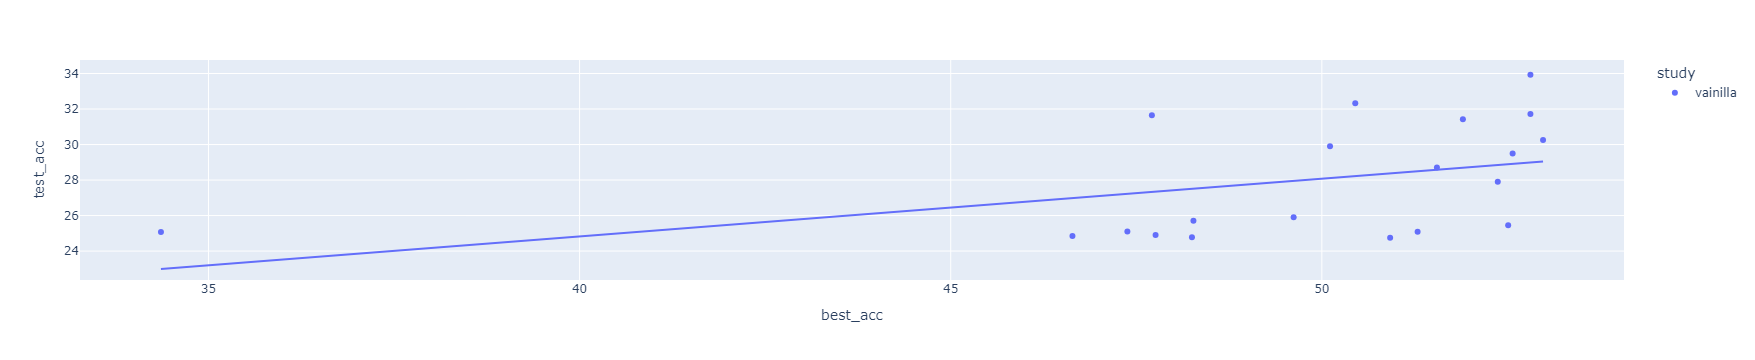

In [142]:
scatter_df=vainilla_students["SE_D"][0]
scatter_df=pd.merge(scatter_df, sorted_df["SE_D"][["name","best_acc"]], on="name")
import plotly.express as px
fig = px.scatter(scatter_df,x="best_acc", y="test_acc",color='study', trendline="ols")
#fig.add_scatter(x=x, y=y_std, mode='markers', name='Data2',trendline="ols", marker=dict(color='green'))
fig.show()

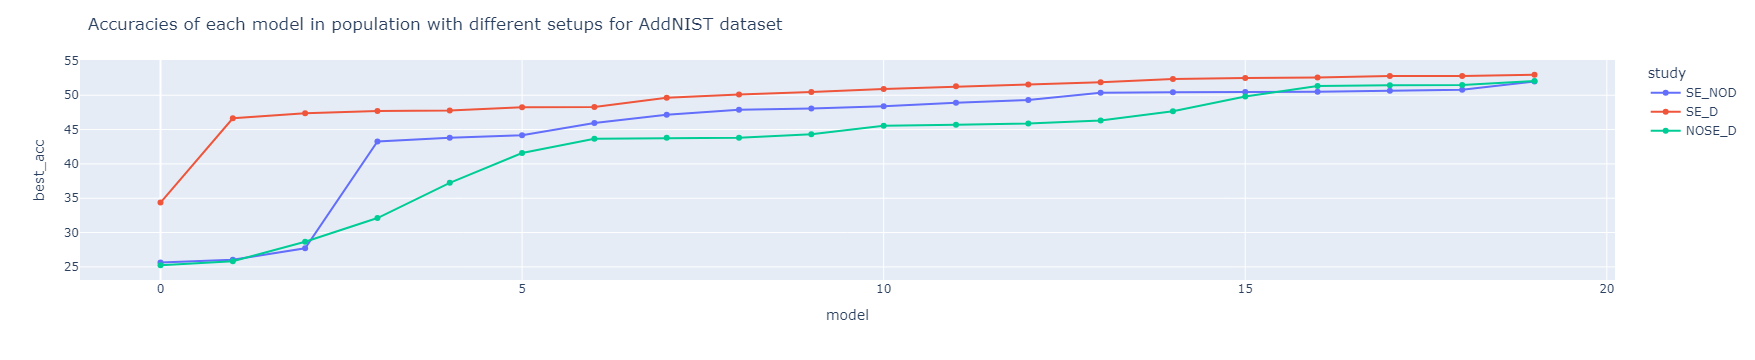

In [10]:
scatter_df=pd.concat([sorted_df["SE_NOD"],sorted_df["SE_D"], sorted_df["NOSE_D"]])

import plotly.express as px

fig = px.line(scatter_df,x="level_0", y="best_acc",color='study', markers=True)
#fig.add_scatter(x=x, y=y_std, mode='markers', name='Data2',trendline="ols", marker=dict(color='green'))
fig.update_layout(height=700)
fig.update_layout(xaxis_title='model', title="Accuracies of each model in population with different setups for AddNIST dataset")
fig.show()


In [7]:
sorted_df["SE_NOD"]

level_0  index  epoch        lr  train_acc  train_loss  best_acc  \
0         0     84      5  0.009045      25.17        1.39     25.63   
1         1    317     18  0.000545      25.42        1.39     26.03   
2         2     19     20  0.001464      27.24        1.38     27.71   
3         3    155     16  0.001464      42.72        1.19     43.27   
4         4    217     18  0.000545      43.65        1.17     43.80   
5         5    198     19  0.000245      43.79        1.17     44.17   
6         6    138     19  0.000245      46.17        1.13     45.97   
7         7    357     18  0.000545      47.84        1.10     47.15   
8         8    379     20  0.000062      47.34        1.11     47.87   
9         9     38     19  0.000245      47.83        1.11     48.05   
10       10     78     19  0.000245      49.42        1.07     48.39   
11       11    119     20  0.000245      51.06        1.05     48.91   
12       12    299     20  0.000062      49.66        1.07     49.31   
13       13    178     19  0.000245      50.32        1.06     50.37   
14       14    239     20  0.000062      51.18        1.05     50.42   
15       15    339     20  0.000062      50.98        1.05     50.45   
16       16     59     20  0.000062      50.86        1.05     50.51   
17       17    399     20  0.000062      50.49        1.06     50.64   
18       18    279     20  0.000062      50.15        1.07     50.81   
19       19    259     20  0.000062      52.58        1.02     52.01   

    test_acc_top5  test_loss  epoch_time                  name   study  
0           49.62       1.42      117.21           happy_raven  SE_NOD  
1           50.59       1.43      102.43      magic_sidewinder  SE_NOD  
2           52.81       1.38      105.72      wakeful_mongoose  SE_NOD  
3           71.72       1.18       97.74     heavenly_squirrel  SE_NOD  
4           72.17       1.22       85.15       flying_capuchin  SE_NOD  
5           73.01       1.16       58.59         loutish_tiger  SE_NOD  
6           74.08       1.32       88.57          dynamic_wasp  SE_NOD  
7           75.83       1.14      128.26  invaluable_cormorant  SE_NOD  
8           75.97       1.11       68.30           optimal_elk  SE_NOD  
9           76.00       1.11       59.20         didactic_zebu  SE_NOD  
10          76.64       1.11       94.93       enormous_limpet  SE_NOD  
11          77.30       1.12      131.52      unselfish_ermine  SE_NOD  
12          77.49       1.08       94.70       umber_binturong  SE_NOD  
13          78.14       1.07       74.74        angelic_lizard  SE_NOD  
14          77.97       1.35      122.48         ultra_herring  SE_NOD  
15          78.39       1.06      151.69       agile_barracuda  SE_NOD  
16          78.31       1.07      107.86          lime_vulture  SE_NOD  
17          78.27       1.06       58.39     phenomenal_dragon  SE_NOD  
18          78.54       1.07       84.80         poetic_poodle  SE_NOD  
19          79.63       1.03       80.54     whimsical_lemming  SE_NOD

In [18]:
corr_coeff_vainilla[name]

index         0 study
0       0  0.431218  SE_D
1       1  0.520268  SE_D
2       2  0.694358  SE_D
3       3  0.702453  SE_D
4       4  0.782447  SE_D
5       5  0.925774  SE_D
6       6  0.918044  SE_D
7       7  0.888181  SE_D
8       8  0.939186  SE_D
9       9  0.976391  SE_D
10     10  0.968793  SE_D
11     11  0.956283  SE_D
12     12  0.961321  SE_D
13     13  0.993168  SE_D
14     14  0.991921  SE_D
15     15  0.996535  SE_D
16     16  0.997022  SE_D
17     17  0.998195  SE_D
18     18  0.999272  SE_D
19     19  0.999783  SE_D

In [173]:
def scatter_results(chromosomes,columny,columnx="flops",results_path=None):
    """
    Creates a scatter plot of FLOPS (Floating Point Operations Per Second) versus a specified column's values
    for each chromosome.

    Args:
        chromosomes (dict): A dictionary where keys represent chromosome names and values represent
            information about the chromosome, including FLOPS ('flops'), WA ('Width slope'), W0 ('Initial width'), WM ('Width multiplier'), DEPTH ('Total depth')m.
        column (str): The name of the column from the chromosome information to plot against FLOPS.

    Returns:
        plotly.graph_objs._figure.Figure: A Plotly figure displaying a scatter plot of FLOPS versus
            the specified column's values for each chromosome.

    """
    chromosomes_df=pd.DataFrame(chromosomes).T.reset_index().rename(columns={"index":"name"})
    if results_path is not None:
        results_df=pd.read_csv(results_path, index_col=0)[["name","best_acc","epoch_time"]]
        chromosomes_df=pd.merge(chromosomes_df,results_df, on="name", how="left")
    chromosomes_df["W0/WA"]=chromosomes_df["W0"]/chromosomes_df["WA"]
    chromosomes_df["W0/WA"]=chromosomes_df["W0/WA"].round(2)
    fig = go.Figure(data=go.Scatter(
        x=chromosomes_df[columnx],
        y=chromosomes_df[columny],
        mode='markers',
        #marker=dict(
        #    size=2,
            #color=np.random.randn(500), #set color equal to a variable
            #colorscale='Viridis', # one of plotly colorscales
            #showscale=True
        #),
        marker=dict(
            size=10
        ),
        text=chromosomes_df['name']
    ))
    layout = go.Layout(
        title='',
        xaxis=dict(title=columnx),
        yaxis=dict(title=columny),
        template="presentation"
    )
    fig.layout=layout
    return fig

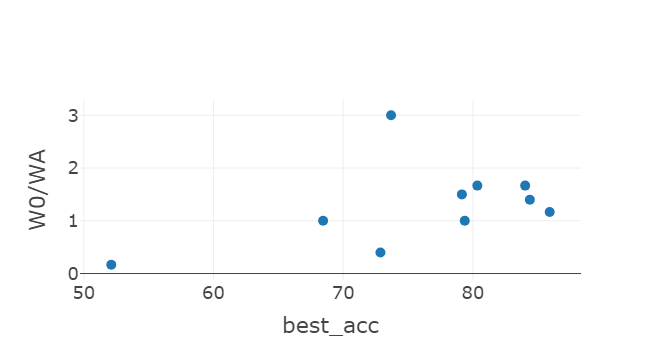

In [156]:
scatter_results(chromosomes,  "W0/WA","best_acc","tests_one_model/Generation_1_NOSE_D/results.csv")

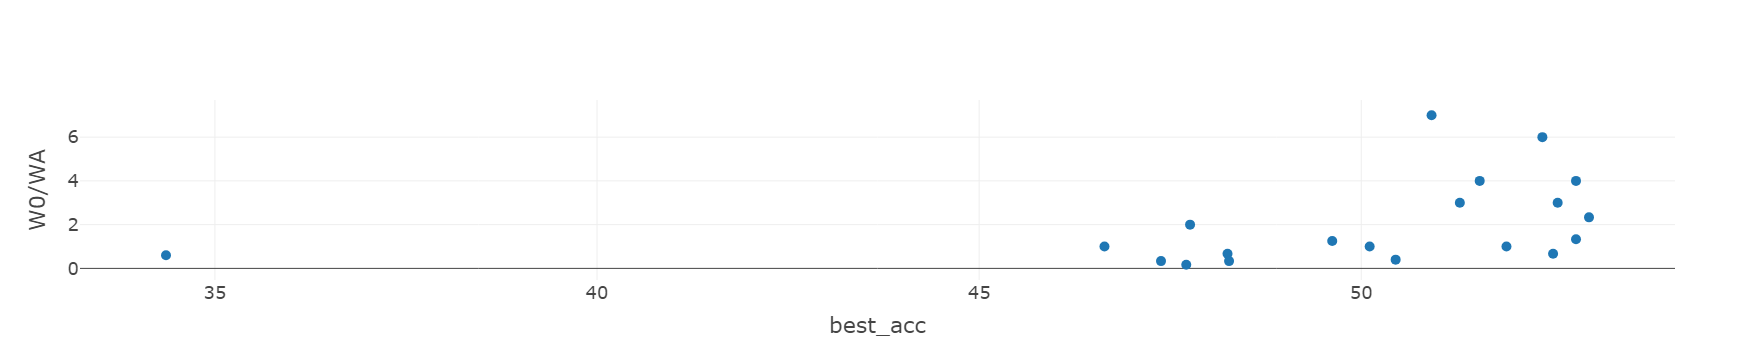

In [154]:
scatter_results(chromosomes,  "W0/WA","best_acc","tests_cifar_tile/Generation_1_SE_D/results.csv")

In [11]:
def _generate_regnet(w_a, w_0, w_m, d, q=8):
        """Generates per stage widths and depths from RegNet parameters."""
        assert w_a >= 0 and w_0 > 0 and w_m > 1 and w_0 % q == 0
        # Generate continuous per-block ws
        ws_cont = np.arange(d) * w_a + w_0
        print("ws_cont: ",ws_cont)
        # Generate quantized per-block ws
        ks = np.round(np.log(ws_cont / w_0) / np.log(w_m))
        print("ks: ",ks)
        #print("ks: ",ks)
        ws_all = w_0 * np.power(w_m, ks)
        ws_all = np.round(np.divide(ws_all, q)).astype(int) * q
        print("ws_all:", ws_all)
        # Generate per stage ws and ds (assumes ws_all are sorted)
        ws, ds = np.unique(ws_all, return_counts=True)
        # Compute number of actual stages and total possible stages
        num_stages, total_stages = len(ws), ks.max() + 1
        print("num_stages", num_stages)
        print("total_stages",total_stages)
        # Convert numpy arrays to lists and return
        ws, ds, ws_all, ws_cont = (x.tolist() for x in (ws, ds, ws_all, ws_cont))
        return ws, ds, num_stages, total_stages, ws_all, ws_cont

In [158]:

chromosomes["olive_wasp"]
#chromosomes["honest_saluki"]
#chromosomes["zircon_toad"]
#chromosomes["hypersonic_sambar"]
#hypersonic_zambar
#quizzical_caiman

{'ws': [8, 72, 144, 288, 592, 1216],
 'bs': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'gs': [8, 8, 8, 8, 8, 8],
 'ds': [1, 1, 3, 4, 9, 2],
 'num_stages': 6,
 'total_size_mb': 62.95697021484375,
 'h': 1,
 'w': 1,
 'flops': 2793680,
 'params': 16503792,
 'acts': 11504,
 'WA': 48.0,
 'W0': 8,
 'WM': 2.05,
 'DEPTH': 20,
 'GROUP_W': 8}

In [130]:
_generate_regnet(40, 32, 2.2, 14, q=8)

ws_cont:  [ 32  72 112 152 192 232 272 312 352 392 432 472 512 552]
ks:  [0. 1. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 4. 4.]
ws_all: [ 32  72 152 152 152 344 344 344 344 344 344 344 752 752]
num_stages 5
total_stages 5.0


([32, 72, 152, 344, 752],
 [1, 1, 3, 7, 2],
 5,
 5.0,
 [32, 72, 152, 152, 152, 344, 344, 344, 344, 344, 344, 344, 752, 752],
 [32, 72, 112, 152, 192, 232, 272, 312, 352, 392, 432, 472, 512, 552])

# Geosclassing

In [2]:
metadata={'input_shape': [50000, 3, 64, 64],
 'codename': 'Sadie',
 'benchmark': 80.33,
 'num_classes': 10,
 'rand_augment': False}
regnet_space=RegNet(metadata,
                    W0=[16, 64, 8],
                    WA=[8, 48, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,8,8], 
                    base_config="../configs/search_space/config.yaml")
test_folder="test_dist_population"
generation=1
#models, chromosomes=regnet_space.create_first_generation(save_folder=test_folder,gen=generation, size=20, config_updates=None)

In [3]:
#WA,W0,WM,DEPTH=48,24,2.4,12
test_folder="tests_geoclassing"
generation=1
config_updates=None
models, chromosomes=regnet_space.load_generation(folder=f"{test_folder}/Generation_{generation}", config_updates=config_updates)


res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0, 'dropout_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0, 'dropout_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0, 'dropout_rate': 0.0}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.0, 'dropout_rate': 0.0}
{'stem_type': 'res_stem_cifar', 'stem_w': 64, 'block_type': 'res_bottleneck_block', 'depths': [1, 3, 10, 3], 'widths': [48, 136, 400, 1168], 'strides': [2, 2, 2, 2], 'bot_muls': [1.0, 1.0, 1.0, 1.0], 'group_ws': [8, 8, 8, 8], 'head_w': 0, 'se_r': 0.25, 'num_classes': 10, 'downsample': 'avg', 'drop_path_rate': 0.0, 'dropout_rate': 0.0}
Loading model: tests_geoclassing/Generation_1/cautious_chipmunk/config.yaml
res_bottleneck_block
res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 

In [7]:
folders=["tests_geoclassing/Generation_1_SE_D_warmup_labels01_s1", "tests_geoclassing/Generation_1_SE_D_s1"]
sorted_df={}
corr_coeff_vainilla={}
vainilla_students={}
order_students={}
for folder in folders:#
    name=f"{folder.split("/")[1][13:]}"
    try:
        order_students[name], sorted_df[name], vainilla_students[name], corr_coeff=get_vainilla_dfs(folder, 20, True)
    except:
        order_students[name], sorted_df[name], vainilla_students[name], corr_coeff=get_vainilla_dfs(folder, 2, True)
    sorted_df[name]["study"]=name
    sorted_df[name]= sorted_df[name].reset_index().reset_index()
    corr_coeff_vainilla[name]=pd.DataFrame(corr_coeff).reset_index()
    corr_coeff_vainilla[name]["study"]=name

['cautious_chipmunk', 'cobalt_wildebeest', 'amber_otter', 'lavender_partridge', 'fascinating_binturong', 'resolute_degu', 'pristine_sturgeon', 'ambrosial_iguana', 'jolly_chupacabra', 'shaggy_alpaca', 'fractal_buzzard', 'garrulous_swan', 'independent_unicorn', 'mutant_baboon', 'lemon_panther', 'fat_vulture', 'apricot_numbat', 'saffron_shrimp', 'results.csv', 'sly_orca', 'nocturnal_caribou']
['cautious_chipmunk', 'cobalt_wildebeest', 'amber_otter', 'lavender_partridge', 'fascinating_binturong', 'resolute_degu', 'pristine_sturgeon', 'ambrosial_iguana', 'jolly_chupacabra', 'shaggy_alpaca', 'fractal_buzzard', 'garrulous_swan', 'independent_unicorn', 'mutant_baboon', 'lemon_panther', 'fat_vulture', 'apricot_numbat', 'saffron_shrimp', 'sly_orca', 'nocturnal_caribou']


In [24]:
sorted_df[name]

level_0  index  epoch        lr  train_acc  train_loss  best_acc  \
0         0    218     19  0.000245      90.74        0.27     85.26   
1         1    336     17  0.000955      88.78        0.32     86.49   
2         2    316     17  0.000955      91.87        0.23     88.10   
3         3    395     16  0.001464      90.78        0.26     88.13   
4         4    159     20  0.000062      96.01        0.11     88.96   
5         5    299     20  0.000062      94.84        0.15     89.17   
6         6    117     18  0.000545      94.47        0.16     89.23   
7         7    277     18  0.000545      94.69        0.15     89.32   
8         8     19     20  0.000062      96.56        0.10     89.35   
9         9    238     19  0.000245      95.27        0.14     89.35   
10       10     98     19  0.000245      95.50        0.13     89.83   
11       11    358     19  0.000245      96.66        0.10     90.11   
12       12    176     17  0.000955      94.39        0.16     90.47   
13       13     39     20  0.000062      94.53        0.16     90.64   
14       14    378     19  0.000545      94.83        0.64     90.65   
15       15    257     18  0.000545      95.90        0.12     90.85   
16       16     78     19  0.000245      95.36        0.13     90.86   
17       17    135     16  0.001464      93.02        0.20     91.10   
18       18    196     17  0.000955      94.45        0.16     91.16   
19       19     58     19  0.000245      95.80        0.13     92.21   

    test_acc_top5  test_loss  epoch_time                   name    study  
0           94.93       0.69       71.28        fractal_buzzard  SE_D_s1  
1           95.50       0.39       76.99         apricot_numbat  SE_D_s1  
2           96.07       0.35       62.95            fat_vulture  SE_D_s1  
3           96.04       0.35       77.52      nocturnal_caribou  SE_D_s1  
4           96.13       0.72      114.73       ambrosial_iguana  SE_D_s1  
5           96.69       0.44      120.74          lemon_panther  SE_D_s1  
6           96.51       0.32       72.30          resolute_degu  SE_D_s1  
7           96.63       0.37       94.28          mutant_baboon  SE_D_s1  
8           96.43       0.73      154.54      cautious_chipmunk  SE_D_s1  
9           96.66       0.32       83.42         garrulous_swan  SE_D_s1  
10          96.95       0.31       81.79  fascinating_binturong  SE_D_s1  
11          96.65       2.14      143.15         saffron_shrimp  SE_D_s1  
12          97.34       0.28       65.21       jolly_chupacabra  SE_D_s1  
13          96.88       0.29       70.02      cobalt_wildebeest  SE_D_s1  
14          96.87       0.76      111.94               sly_orca  SE_D_s1  
15          97.35       0.47      105.85    independent_unicorn  SE_D_s1  
16          97.22       0.28       85.28     lavender_partridge  SE_D_s1  
17          97.26       0.27       95.03      pristine_sturgeon  SE_D_s1  
18          97.18       0.27       90.47          shaggy_alpaca  SE_D_s1  
19          98.10       0.23      131.11            amber_otter  SE_D_s1

In [19]:
#sorted_df[name].to_csv("tests_geoclassing/Generation_1_SE_D_warmup_labels01_s1/results.csv")

In [6]:
kd_students, corr_coeff_kd=get_students_dfs("tests_geoclassing/Generation_1_SE_D_s1_dropout_randaugment", 3, sorted_df["SE_D"],order_students["SE_D"], "SE_D_label", corr=True, corr_n=20)

In [5]:
corr_coeff_kd

[0.6586697576744236, 0.363109160212504, 0.5034108715670507]

In [17]:
kd_students[0].sort_values("test_acc_top5")

epoch        lr  train_acc  train_loss  test_acc  test_acc_top5  \
48      1  0.000029      27.77        2.05     40.33          57.67   
0       1  0.000029      31.81        2.05     43.10          62.19   
30      1  0.000029      27.01        2.07     41.57          62.79   
3       1  0.000029      33.61        1.94     42.29          63.57   
51      1  0.000029      30.39        2.11     45.90          64.29   
57      1  0.000029      30.78        1.99     45.55          64.93   
21      1  0.000029      30.86        2.04     47.56          64.96   
42      1  0.000029      26.84        2.06     45.08          65.26   
12      1  0.000029      33.30        1.95     48.25          66.72   
27      1  0.000029      32.22        1.98     47.64          66.81   
6       1  0.000029      33.38        1.93     46.93          67.32   
36      1  0.000029      30.99        2.06     49.03          67.51   
39      1  0.000029      33.28        1.98     49.82          68.59   
15      1  0.000029      34.21        1.92     48.26          68.63   
18      1  0.000029      32.70        1.95     47.09          68.67   
33      1  0.000029      33.48        1.96     49.72          68.95   
54      1  0.000029      30.52        2.05     50.30          69.80   
45      1  0.000029      32.19        1.96     49.11          69.87   
24      1  0.000029      34.92        1.93     52.98          71.12   
9       1  0.000029      33.17        1.94     51.69          71.16   

    test_loss  epoch_time                   name       study  
48       1.69       92.00         apricot_numbat  SE_D_label  
0        2.82      169.87      cautious_chipmunk  SE_D_label  
30       1.88       95.63        fractal_buzzard  SE_D_label  
3        2.32       91.85      cobalt_wildebeest  SE_D_label  
51       2.04      157.75         saffron_shrimp  SE_D_label  
57       1.70      104.03      nocturnal_caribou  SE_D_label  
21       2.35      132.12       ambrosial_iguana  SE_D_label  
42       1.98      126.06          lemon_panther  SE_D_label  
12       1.87       97.24  fascinating_binturong  SE_D_label  
27       1.61      104.99          shaggy_alpaca  SE_D_label  
6        2.08      145.68            amber_otter  SE_D_label  
36       1.95      124.34    independent_unicorn  SE_D_label  
39       1.67      113.98          mutant_baboon  SE_D_label  
15       2.17       93.21          resolute_degu  SE_D_label  
18       1.67      112.44      pristine_sturgeon  SE_D_label  
33       1.71      101.40         garrulous_swan  SE_D_label  
54       1.84      126.97               sly_orca  SE_D_label  
45       1.69       85.61            fat_vulture  SE_D_label  
24       1.57       85.88       jolly_chupacabra  SE_D_label  
9        1.47      104.97     lavender_partridge  SE_D_label

In [16]:
sorted_df["SE_D_warmup_labels01_s1"]

level_0  index  epoch        lr  train_acc  train_loss  best_acc  \
0         0    218     19  0.000545      89.21        0.76     84.92   
1         1    339     20  0.000245      88.61        0.78     85.04   
2         2    398     19  0.000545      91.53        0.72     87.05   
3         3    119     20  0.000245      94.36        0.65     88.47   
4         4    319     20  0.000245      91.30        0.73     88.79   
5         5    255     16  0.002061      92.83        0.67     89.27   
6         6     18     19  0.000545      95.40        0.62     89.40   
7         7    299     20  0.000245      93.88        0.66     89.97   
8         8    275     16  0.002061      92.56        0.69     90.17   
9         9    356     17  0.001464      93.56        0.66     90.27   
10       10     36     17  0.001464      92.20        0.71     90.31   
11       11     57     18  0.000955      94.19        0.66     90.54   
12       12    136     17  0.001464      92.94        0.70     90.59   
13       13    378     19  0.000545      94.83        0.64     90.65   
14       14     96     17  0.001464      93.77        0.67     90.70   
15       15     79     20  0.000245      94.76        0.64     90.73   
16       16    238     19  0.000545      94.21        0.66     91.06   
17       17    198     19  0.000545      94.52        0.65     91.19   
18       18    176     17  0.001464      93.74        0.67     91.43   
19       19    159     20  0.000245      95.07        0.63     91.43   

    test_acc_top5  test_loss  epoch_time                   name  \
0           94.48       0.62       65.79        fractal_buzzard   
1           94.56       0.51       63.73         apricot_numbat   
2           96.08       0.43       77.38      nocturnal_caribou   
3           96.23       0.40       69.17          resolute_degu   
4           95.96       0.40       61.92            fat_vulture   
5           96.36       0.66      106.14    independent_unicorn   
6           96.22       1.73      158.64      cautious_chipmunk   
7           96.47       1.31      107.10          lemon_panther   
8           96.85       0.36       92.37          mutant_baboon   
9           96.92       0.34      142.52         saffron_shrimp   
10          96.90       0.36       71.26      cobalt_wildebeest   
11          97.22       0.34      131.65            amber_otter   
12          96.99       0.34       95.02      pristine_sturgeon   
13          96.87       0.76      111.94               sly_orca   
14          97.21       0.34       83.41  fascinating_binturong   
15          97.12       0.34       84.78     lavender_partridge   
16          97.14       0.33       80.65         garrulous_swan   
17          96.98       0.35       88.97          shaggy_alpaca   
18          97.47       0.32       62.60       jolly_chupacabra   
19          97.21       0.39      113.51       ambrosial_iguana   

                      study  
0   SE_D_warmup_labels01_s1  
1   SE_D_warmup_labels01_s1  
2   SE_D_warmup_labels01_s1  
3   SE_D_warmup_labels01_s1  
4   SE_D_warmup_labels01_s1  
5   SE_D_warmup_labels01_s1  
6   SE_D_warmup_labels01_s1  
7   SE_D_warmup_labels01_s1  
8   SE_D_warmup_labels01_s1  
9   SE_D_warmup_labels01_s1  
10  SE_D_warmup_labels01_s1  
11  SE_D_warmup_labels01_s1  
12  SE_D_warmup_labels01_s1  
13  SE_D_warmup_labels01_s1  
14  SE_D_warmup_labels01_s1  
15  SE_D_warmup_labels01_s1  
16  SE_D_warmup_labels01_s1  
17  SE_D_warmup_labels01_s1  
18  SE_D_warmup_labels01_s1  
19  SE_D_warmup_labels01_s1

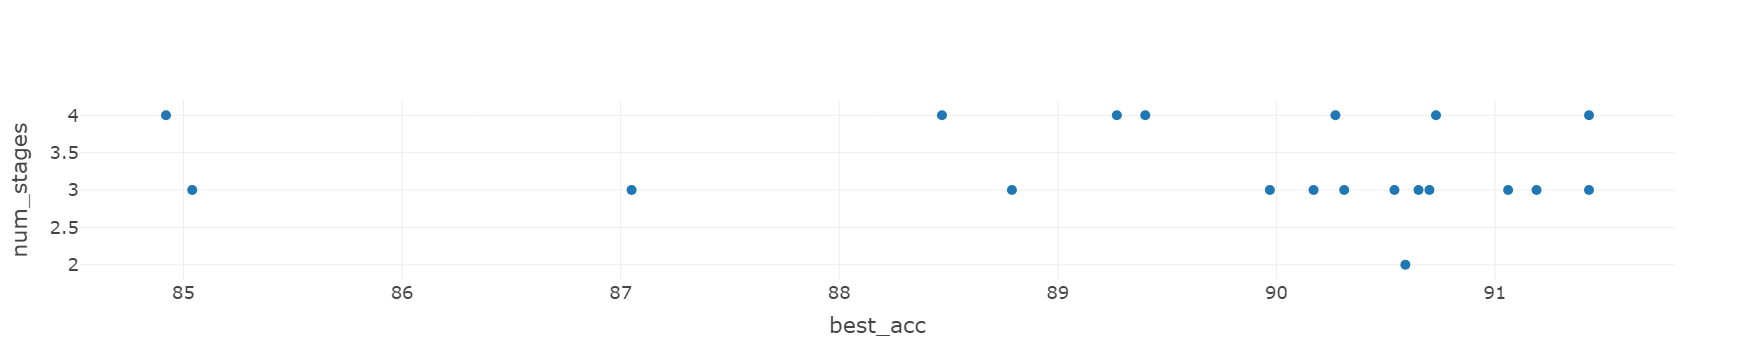

In [8]:
scatter_results(chromosomes,  "num_stages","best_acc","tests_geoclassing/Generation_1_SE_D_warmup_labels01_s1/results.csv")

In [32]:
chromosomes

{'cautious_chipmunk': {'ws': [48, 136, 400, 1168],
  'bs': [1.0, 1.0, 1.0, 1.0],
  'gs': [8, 8, 8, 8],
  'ds': [1, 3, 10, 3],
  'num_stages': 4,
  'total_size_mb': 53.53633117675781,
  'h': 1,
  'w': 1,
  'flops': 2389684,
  'params': 14034228,
  'acts': 9684,
  'WA': 48.0,
  'W0': 48,
  'WM': 2.899999999999997,
  'DEPTH': 17,
  'GROUP_W': 8},
 'cobalt_wildebeest': {'ws': [48, 104, 224],
  'bs': [1.0, 1.0, 1.0],
  'gs': [8, 8, 8],
  'ds': [1, 4, 4],
  'num_stages': 3,
  'total_size_mb': 2.7150497436523438,
  'h': 1,
  'w': 1,
  'flops': 111078,
  'params': 711734,
  'acts': 1670,
  'WA': 24.0,
  'W0': 48,
  'WM': 2.1499999999999995,
  'DEPTH': 9,
  'GROUP_W': 8},
 'amber_otter': {'ws': [56, 160, 456],
  'bs': [1.0, 1.0, 1.0],
  'gs': [8, 8, 8],
  'ds': [3, 11, 1],
  'num_stages': 3,
  'total_size_mb': 4.9694671630859375,
  'h': 1,
  'w': 1,
  'flops': 181340,
  'params': 1302716,
  'acts': 2892,
  'WA': 16.0,
  'W0': 56,
  'WM': 2.849999999999997,
  'DEPTH': 15,
  'GROUP_W': 8},
 'lave

In [31]:
num_combinations = 30

# Determine the number of bins per parameter (assuming an equal split)
num_bins = int(np.ceil(num_combinations**(1/3)))  # fourth root of 20

In [4]:
# Generate equally spaced values within the specified ranges
import numpy as np
from itertools import product
import random

# Create the Cartesian product of these values
all_combinations = list(product(regnet_space.WA_OPTIONS, regnet_space.WM_OPTIONS, regnet_space.D_OPTIONS))

num_combinations=25
# Calculate the step sizes based on the desired number of samples
step_size = len(all_combinations) // num_combinations

# Select evenly spaced combinations
selected_combinations = all_combinations[::step_size][:num_combinations]

In [5]:
selected_combinations

[(8, 2.05, 8),
 (8, 2.249999999999999, 12),
 (8, 2.4499999999999984, 16),
 (8, 2.6499999999999977, 20),
 (8, 2.899999999999997, 9),
 (16, 2.1999999999999993, 13),
 (16, 2.3999999999999986, 17),
 (16, 2.599999999999998, 21),
 (16, 2.849999999999997, 10),
 (24, 2.1499999999999995, 14),
 (24, 2.3499999999999988, 18),
 (24, 2.549999999999998, 22),
 (24, 2.799999999999997, 11),
 (32, 2.0999999999999996, 15),
 (32, 2.299999999999999, 19),
 (32, 2.549999999999998, 8),
 (32, 2.7499999999999973, 12),
 (40, 2.05, 16),
 (40, 2.249999999999999, 20),
 (40, 2.4999999999999982, 9),
 (40, 2.6999999999999975, 13),
 (40, 2.899999999999997, 17),
 (48, 2.1999999999999993, 21),
 (48, 2.4499999999999984, 10),
 (48, 2.6499999999999977, 14)]

# Results full NAS

In [1]:
import pandas as pd
import json
import plotly.graph_objects as go
import plotly.express as px

import sys
sys.path.append("../")
from search_space.RegNet import RegNet

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [87]:
test_folder="tests_Caitie_22_05_2024_21_38"
file_path=f"{test_folder}/{test_folder}.evonas"
with open(file_path, 'r') as file:
    results = json.load(file)

In [88]:
results.keys()

dict_keys(['correlation', 'results', 'parents', 'metadata', 'best_model', 'parameters', 'total_time'])

In [89]:
df=pd.read_json(results["results"])

/tmp/ipykernel_430710/3698866666.py:1: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [90]:

def scatter_results(chromosomes_df,columny,columnx):
    """
    Creates a scatter plot of FLOPS (Floating Point Operations Per Second) versus a specified column's values
    for each chromosome.

    Args:
        chromosomes (dict): A dictionary where keys represent chromosome names and values represent
            information about the chromosome, including FLOPS ('flops'), WA ('Width slope'), W0 ('Initial width'), WM ('Width multiplier'), DEPTH ('Total depth')m.
        column (str): The name of the column from the chromosome information to plot against FLOPS.

    Returns:
        plotly.graph_objs._figure.Figure: A Plotly figure displaying a scatter plot of FLOPS versus
            the specified column's values for each chromosome.

    """
    chromosomes_df["generation"]=chromosomes_df["generation"].astype(str)
    fig = px.scatter(
        chromosomes_df,
        x=columny,
        y=columnx,
        #mode='markers',
        color="generation",
        #marker=dict(
        #    size=2,
            #color=np.random.randn(500), #set color equal to a variable
            #colorscale='Viridis', # one of plotly colorscales
            #showscale=True
        #),
        #marker=dict(
        #    size=10
        #),
        #text=chromosomes_df['name']
    )
    #layout = go.Layout(
    #    title='',
    #    xaxis=dict(title=columnx),
    #    yaxis=dict(title=columny),
    #    template="presentation"
    #)
    #fig.layout=layout
    fig.update_layout(height=600, template="presentation")
    return fig

In [91]:
df

name                         ws               ds  \
0        amaranth_python                   [48, 96]           [3, 5]   
1       ambitious_urchin              [32, 72, 168]        [3, 7, 4]   
2      amorphous_catfish         [16, 40, 104, 264]    [2, 5, 12, 1]   
3      angelic_kittiwake                  [56, 160]           [5, 6]   
4           careful_degu         [40, 88, 192, 424]    [2, 4, 10, 1]   
5     cherry_nightingale                   [40, 96]           [2, 6]   
6       dandelion_turkey             [48, 128, 360]        [2, 9, 3]   
7        daring_crayfish        [48, 104, 208, 448]     [1, 4, 6, 9]   
8       demonic_pheasant             [56, 136, 320]        [2, 5, 4]   
9    imaginary_crocodile             [40, 104, 280]       [2, 4, 11]   
10         kind_silkworm         [40, 80, 168, 344]     [1, 2, 4, 1]   
11       masterful_gecko        [48, 112, 256, 584]     [1, 3, 7, 3]   
12           orchid_mink        [56, 144, 368, 928]    [2, 4, 11, 3]   
13     resourceful_okapi             [40, 112, 328]        [1, 4, 6]   
14          space_python    [40, 88, 192, 424, 936]  [1, 2, 4, 8, 2]   
15      spectral_dolphin             [64, 160, 400]        [1, 4, 3]   
16   thundering_mastodon             [56, 152, 424]        [1, 4, 9]   
17             tidy_newt  [64, 136, 280, 592, 1248]  [1, 2, 5, 9, 3]   
18            vegan_gaur             [64, 152, 368]        [1, 3, 7]   
19    wakeful_rottweiler       [64, 168, 448, 1192]     [1, 4, 9, 3]   
20      calculating_wolf             [48, 120, 304]        [2, 7, 7]   
21   chocolate_crocodile             [48, 112, 264]        [2, 6, 6]   
22        lean_earthworm        [56, 120, 256, 560]     [1, 3, 5, 9]   
23        beryl_labrador         [40, 88, 184, 400]     [1, 3, 6, 3]   
24        curvy_hedgehog        [48, 112, 240, 544]     [1, 3, 5, 9]   
25  transparent_cockatoo             [40, 112, 312]        [1, 4, 8]   
26           speedy_zebu         [40, 88, 184, 400]     [1, 2, 5, 8]   
27      viridian_meerkat         [40, 88, 208, 488]     [1, 3, 7, 1]   
28     industrious_trout             [56, 144, 376]        [2, 7, 4]   
29          topaz_avocet             [56, 136, 320]        [2, 8, 4]   
30        happy_chipmunk        [48, 104, 232, 512]     [1, 3, 6, 2]   
31      offbeat_mackerel             [48, 104, 240]        [2, 8, 3]   
32     infrared_starling         [40, 96, 248, 624]     [1, 4, 8, 3]   
33          elite_toucan             [48, 112, 240]        [1, 4, 5]   
34         intrepid_puma        [56, 128, 296, 680]     [1, 3, 6, 6]   
35         elite_manatee             [48, 120, 288]        [2, 5, 5]   
36       raspberry_tench         [40, 80, 168, 344]     [2, 3, 8, 1]   
37          portable_ant        [56, 120, 272, 600]     [2, 4, 9, 2]   
38       radiant_pelican        [48, 104, 232, 512]     [1, 2, 5, 5]   
39     satisfied_mouflon         [40, 96, 232, 552]     [1, 3, 6, 1]   
40     abstract_curassow         [32, 64, 144, 296]     [1, 2, 5, 5]   
41       cream_bandicoot        [48, 112, 240, 544]     [1, 4, 8, 2]   
42      demonic_mongoose              [32, 80, 184]        [1, 3, 7]   
43        flashy_hoatzin         [40, 96, 240, 592]     [1, 4, 7, 1]   
44          funky_jaguar        [48, 104, 224, 480]     [2, 4, 8, 2]   
45       ginger_mackerel             [64, 144, 336]        [2, 6, 4]   
46         hasty_waxbill                  [48, 112]           [3, 9]   
47        holistic_llama         [32, 72, 176, 416]     [1, 2, 6, 3]   
48   hopping_caterpillar              [40, 96, 208]       [2, 4, 10]   
49            khaki_puma             [48, 120, 304]        [1, 4, 6]   
50            maize_kiwi         [48, 96, 200, 416]     [1, 3, 5, 3]   
51       massive_bulldog         [32, 72, 168, 392]     [1, 3, 6, 8]   
52            neat_zebra             [72, 176, 416]        [2, 4, 4]   
53   nebulous_kingfisher             [40, 104, 272]        [1, 4, 8]   
54        quartz_leopard         [40, 80, 168, 344]     [1, 

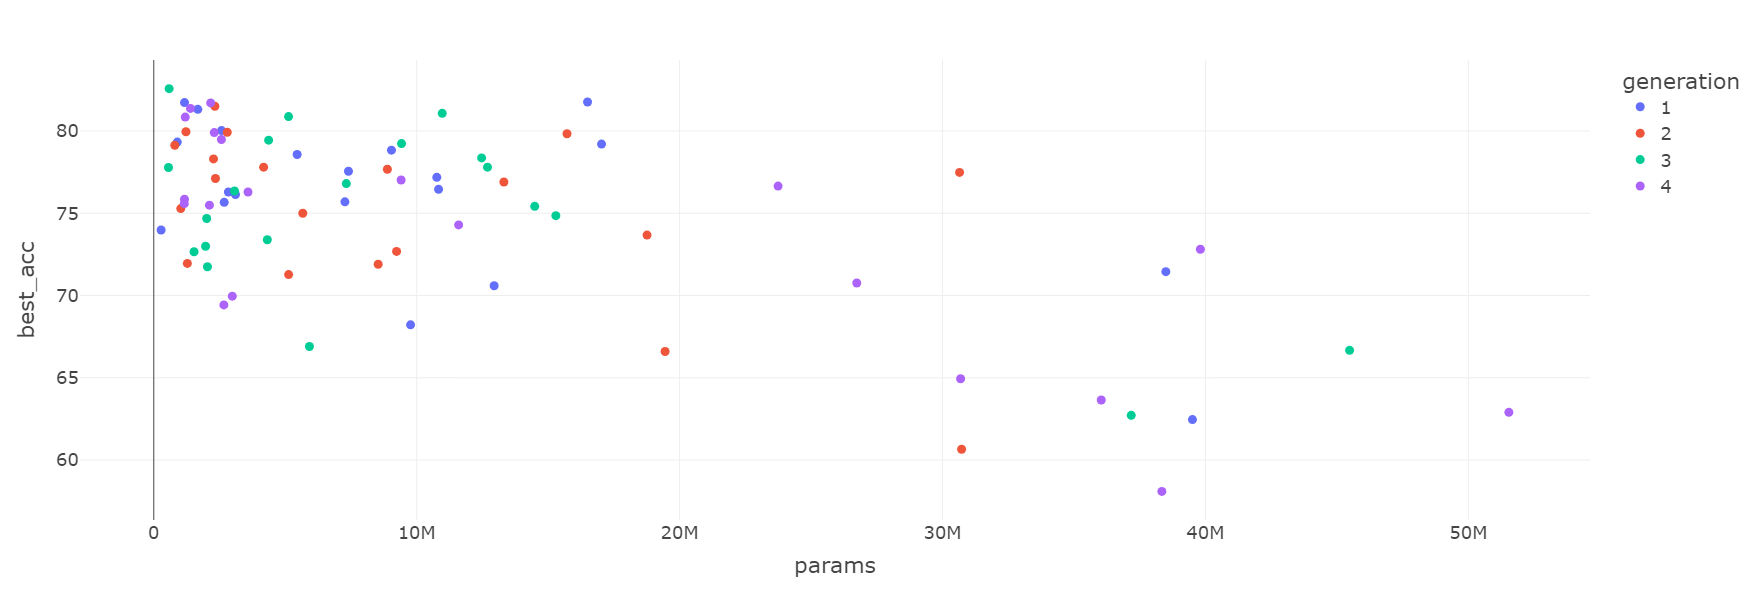

In [75]:
# Random GeoClassing
scatter_results(df, "params","best_acc")

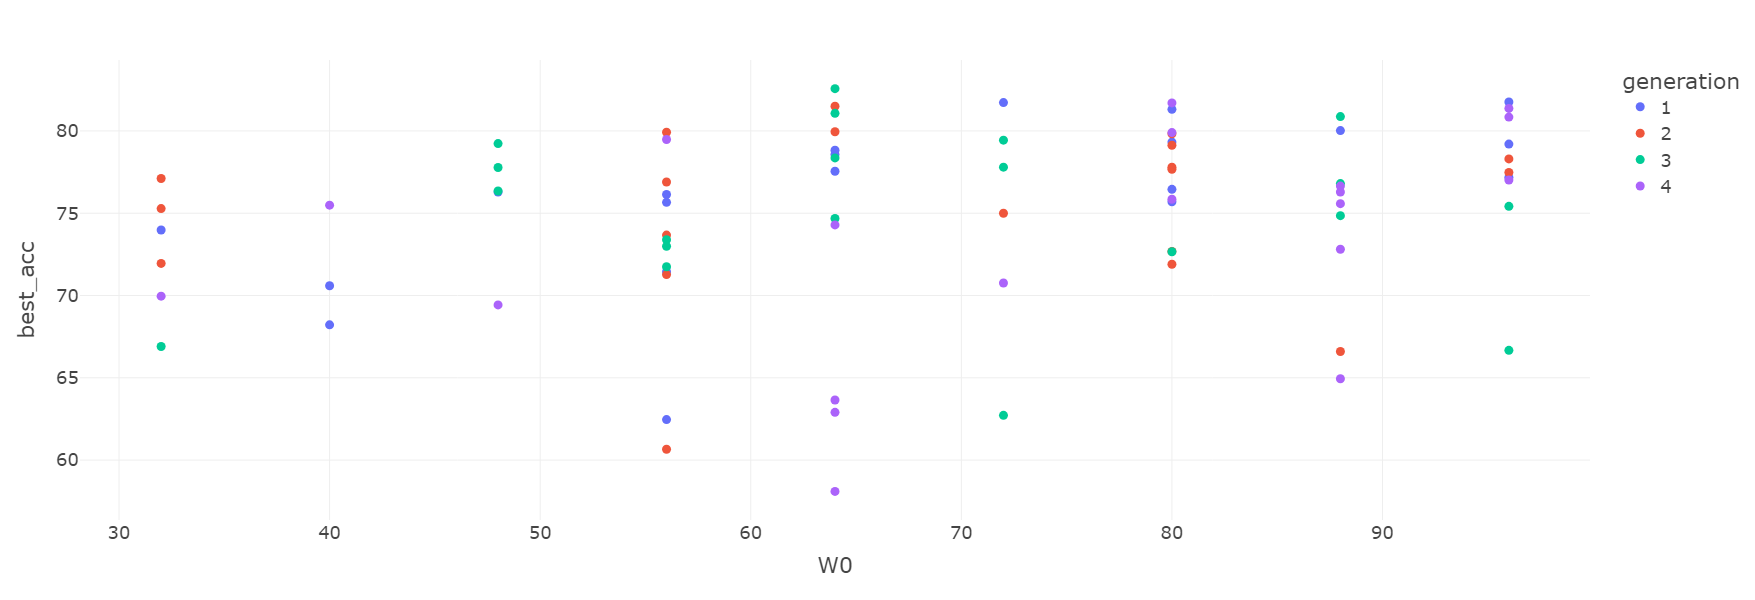

In [57]:
# Random GeoClassing
scatter_results(df, "W0","best_acc")

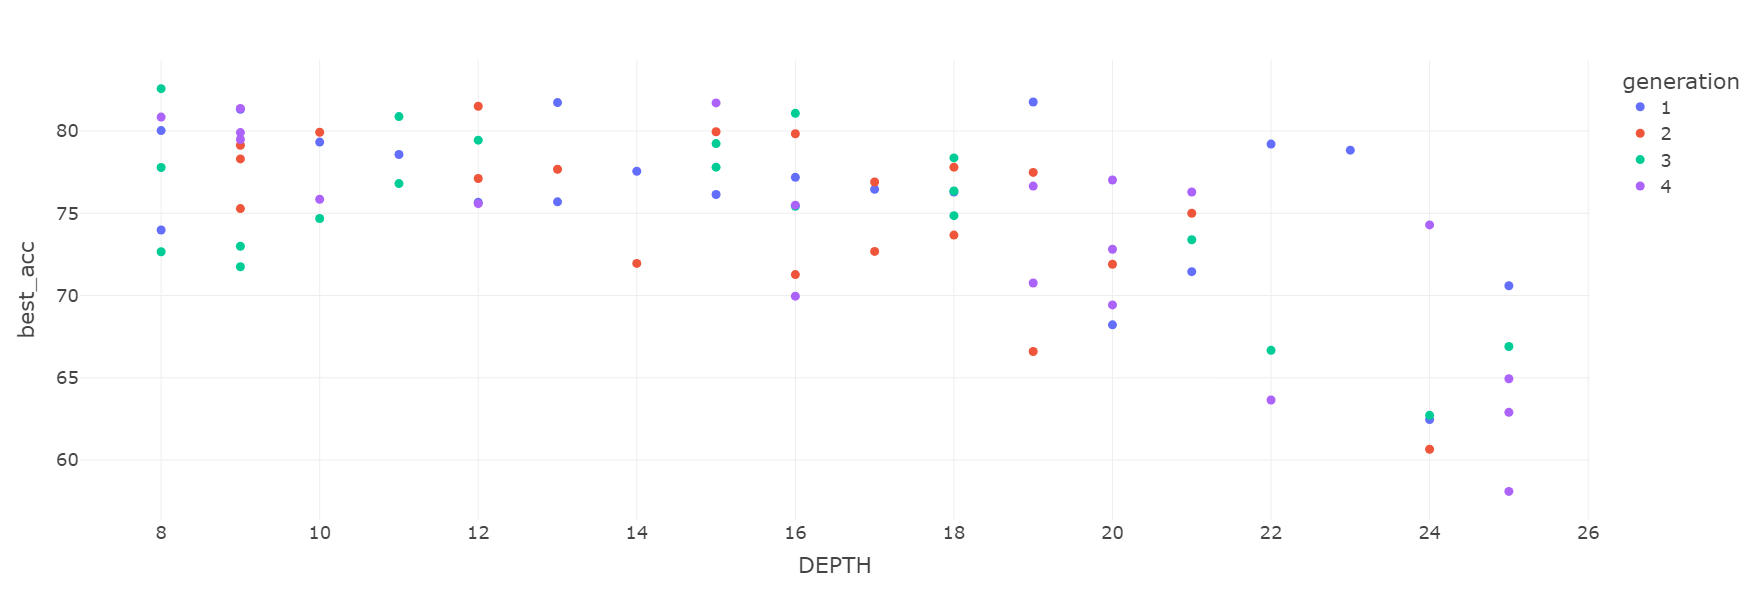

In [58]:
# Random GeoClassing
scatter_results(df, "DEPTH","best_acc")

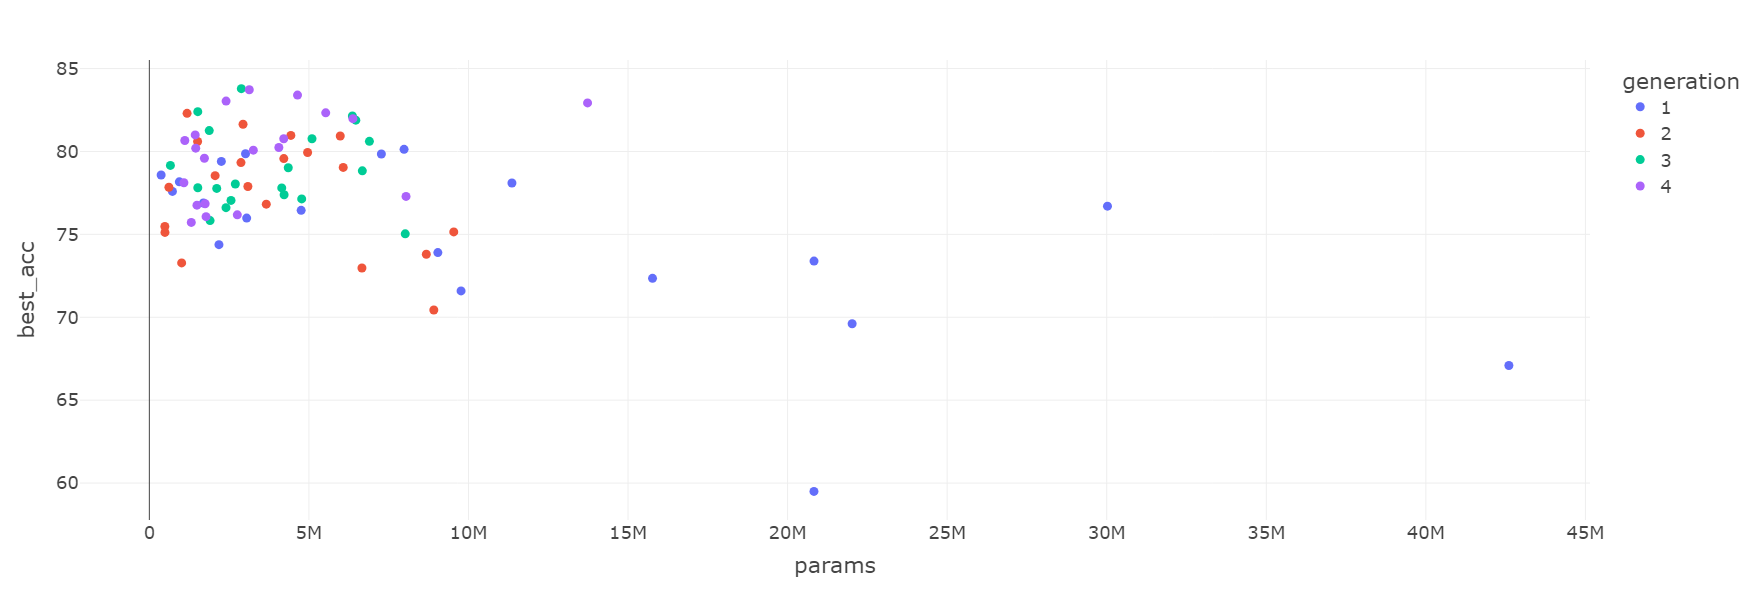

In [69]:
# EvoNas GeoClassing
scatter_results(df, "params","best_acc")

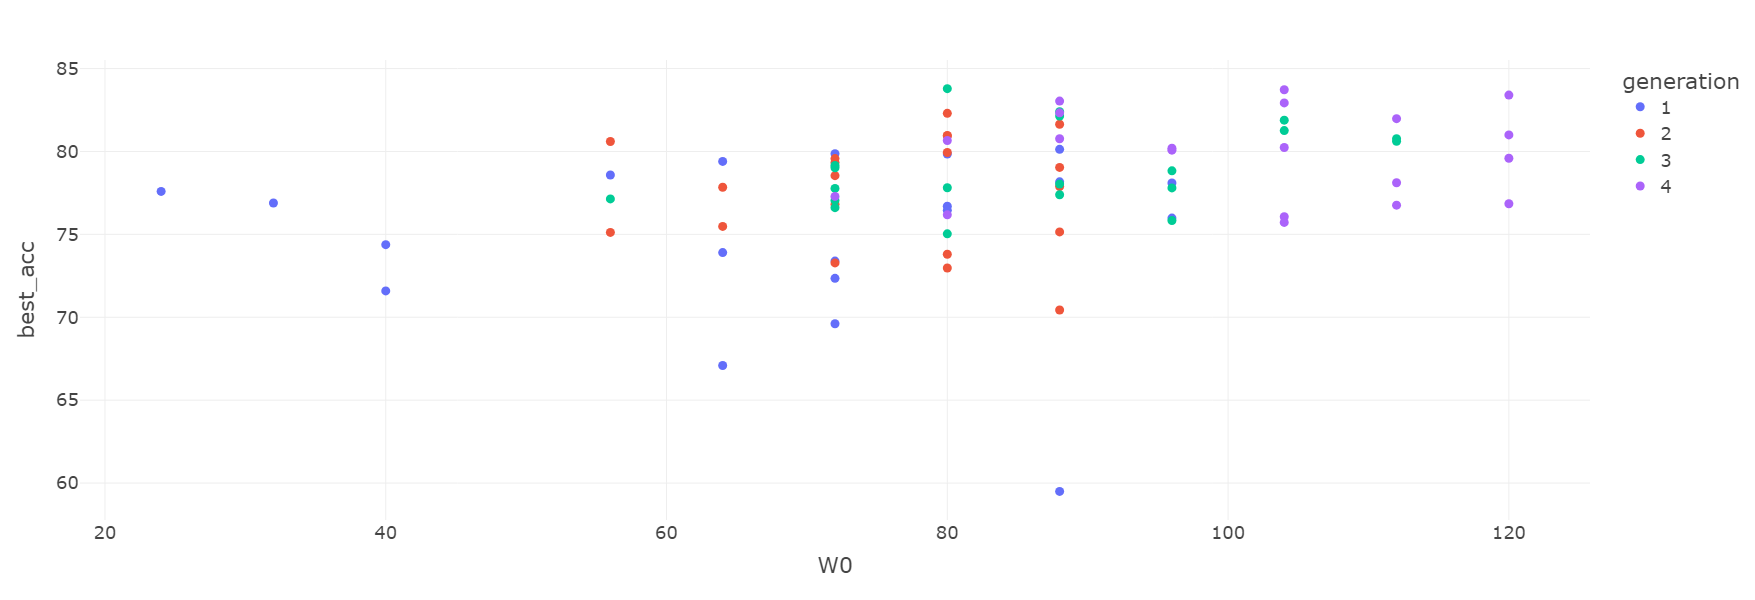

In [ ]:
# EvoNas GeoClassing
scatter_results(df, "W0","best_acc")

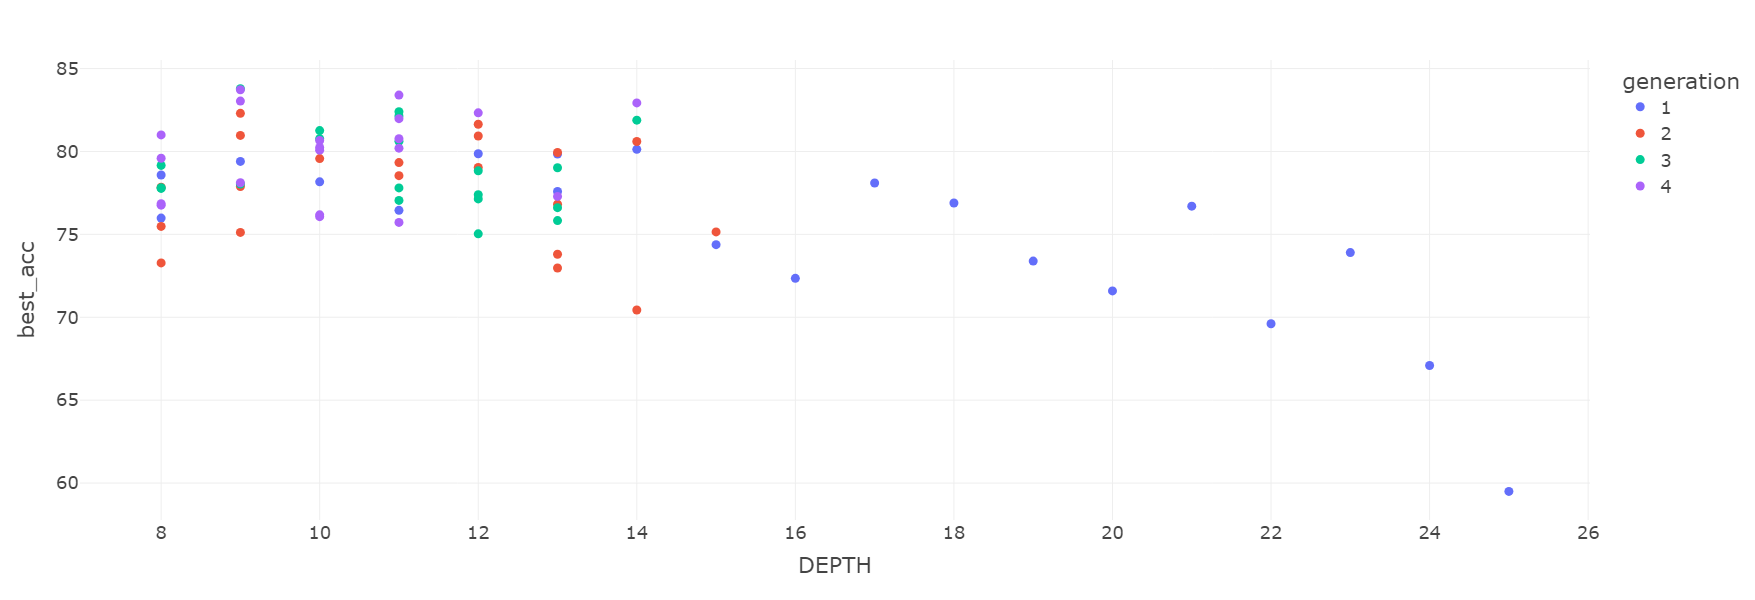

In [65]:
# Evonas GeoClassing
scatter_results(df, "DEPTH","best_acc")

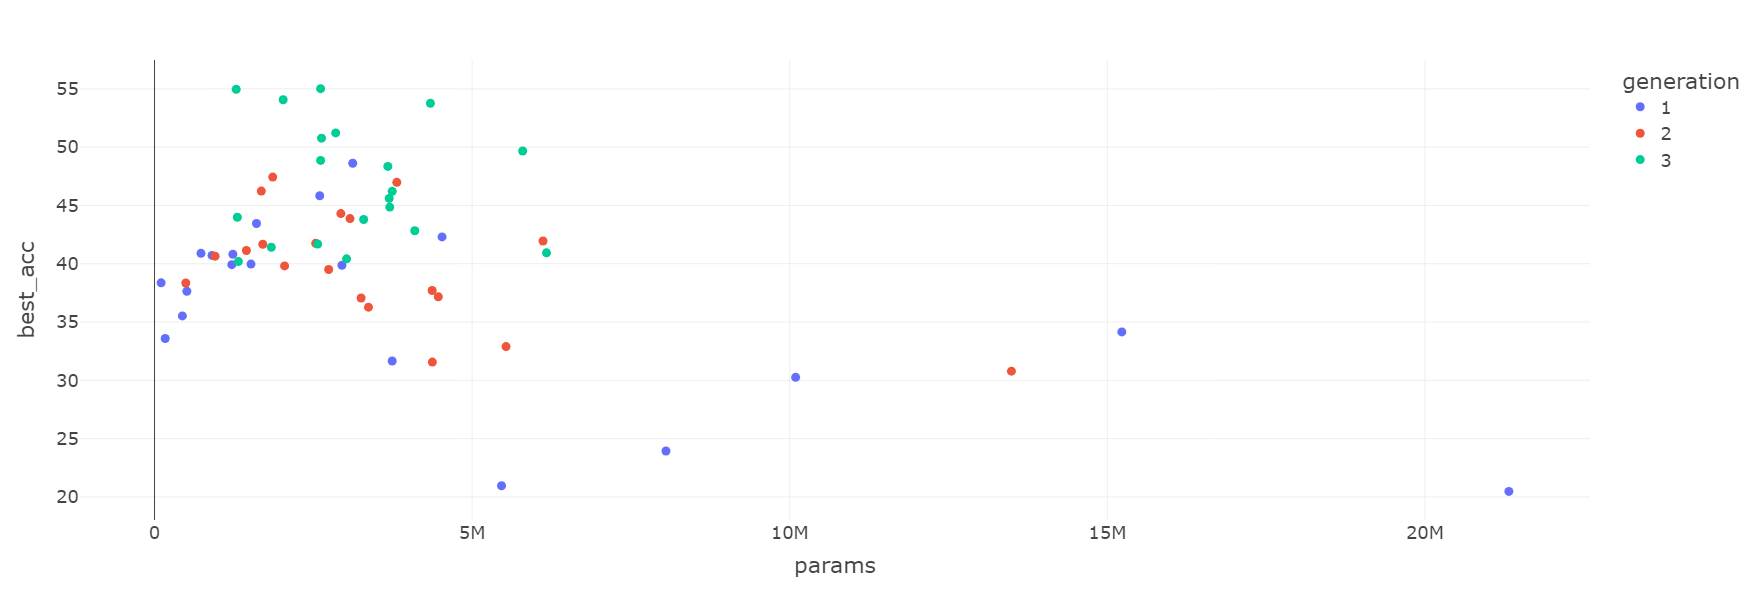

In [81]:
# Evonas AddNIST
scatter_results(df, "params","best_acc")

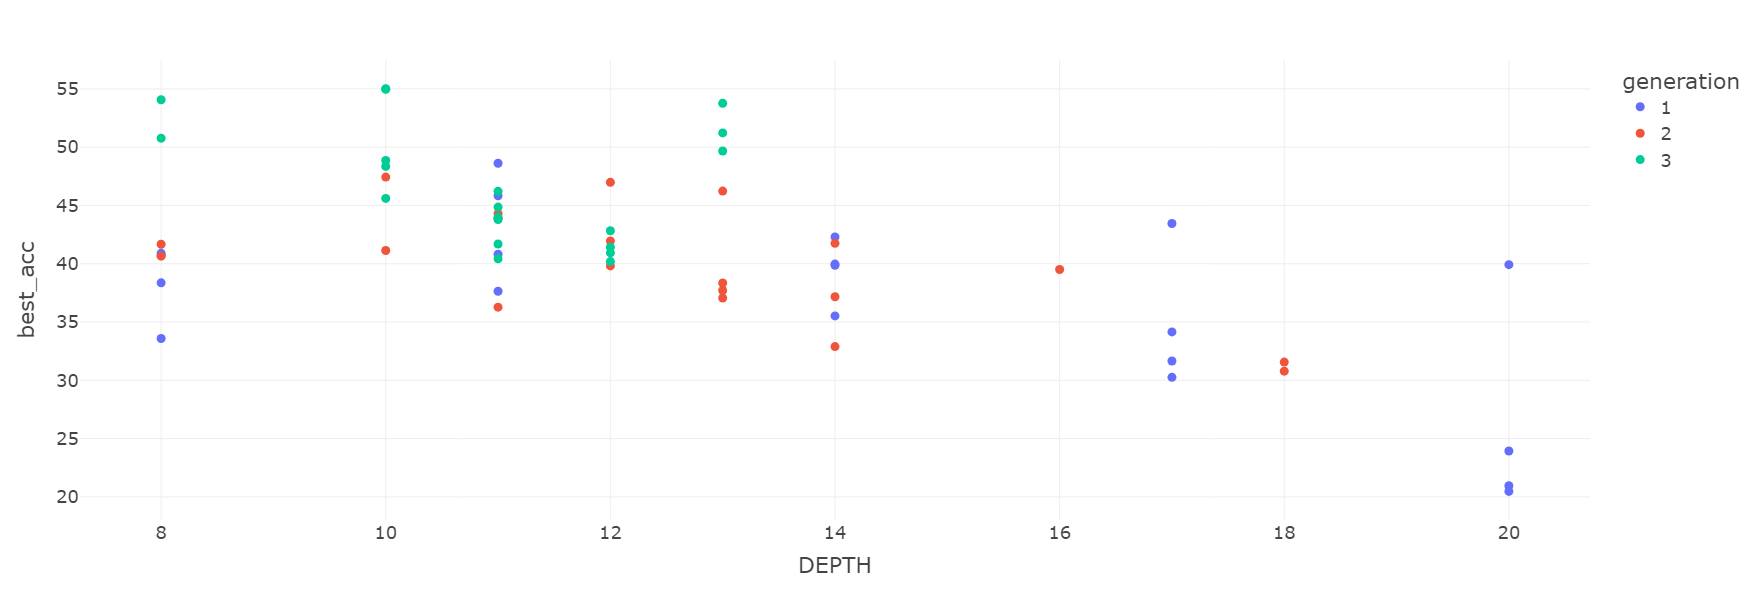

In [82]:
# Evonas AddNIST
scatter_results(df, "DEPTH","best_acc")

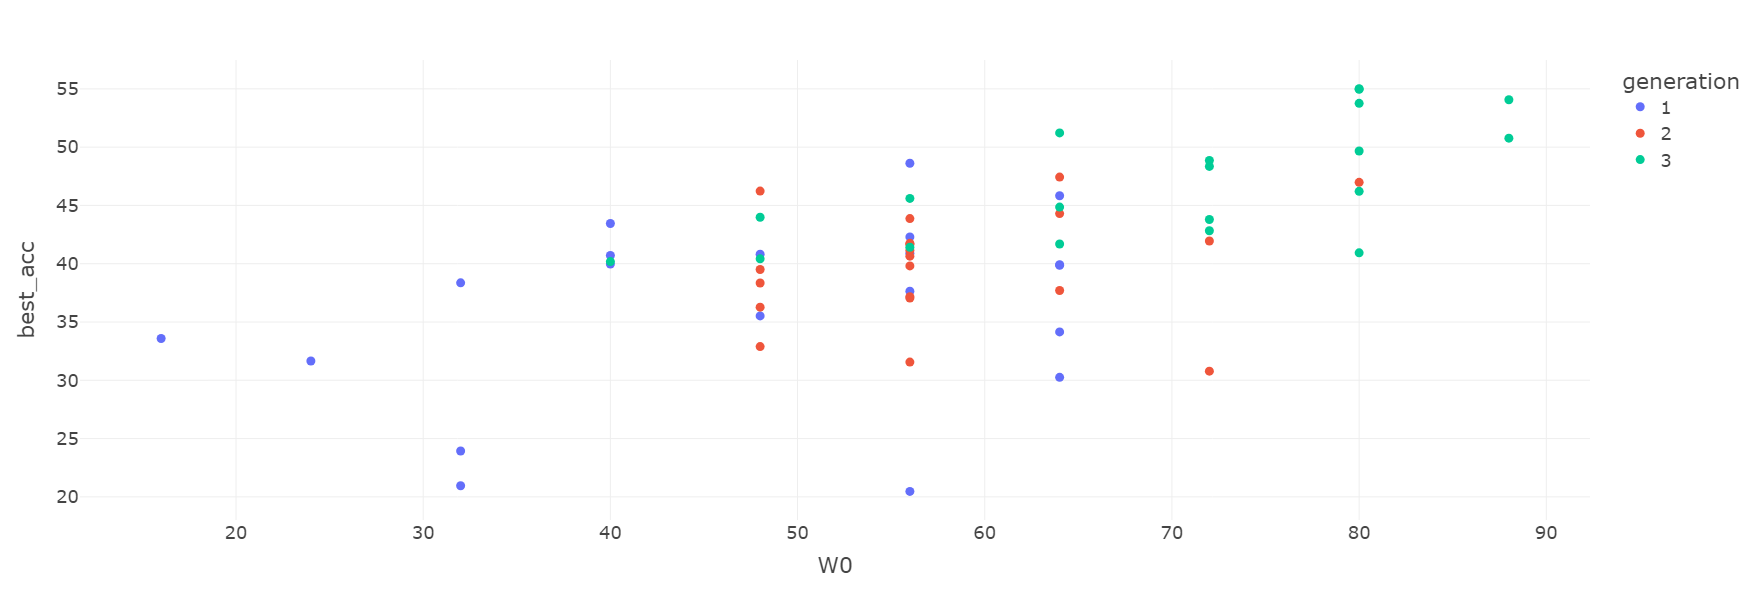

In [86]:
# Evonas AddNIST
scatter_results(df, "W0","best_acc")

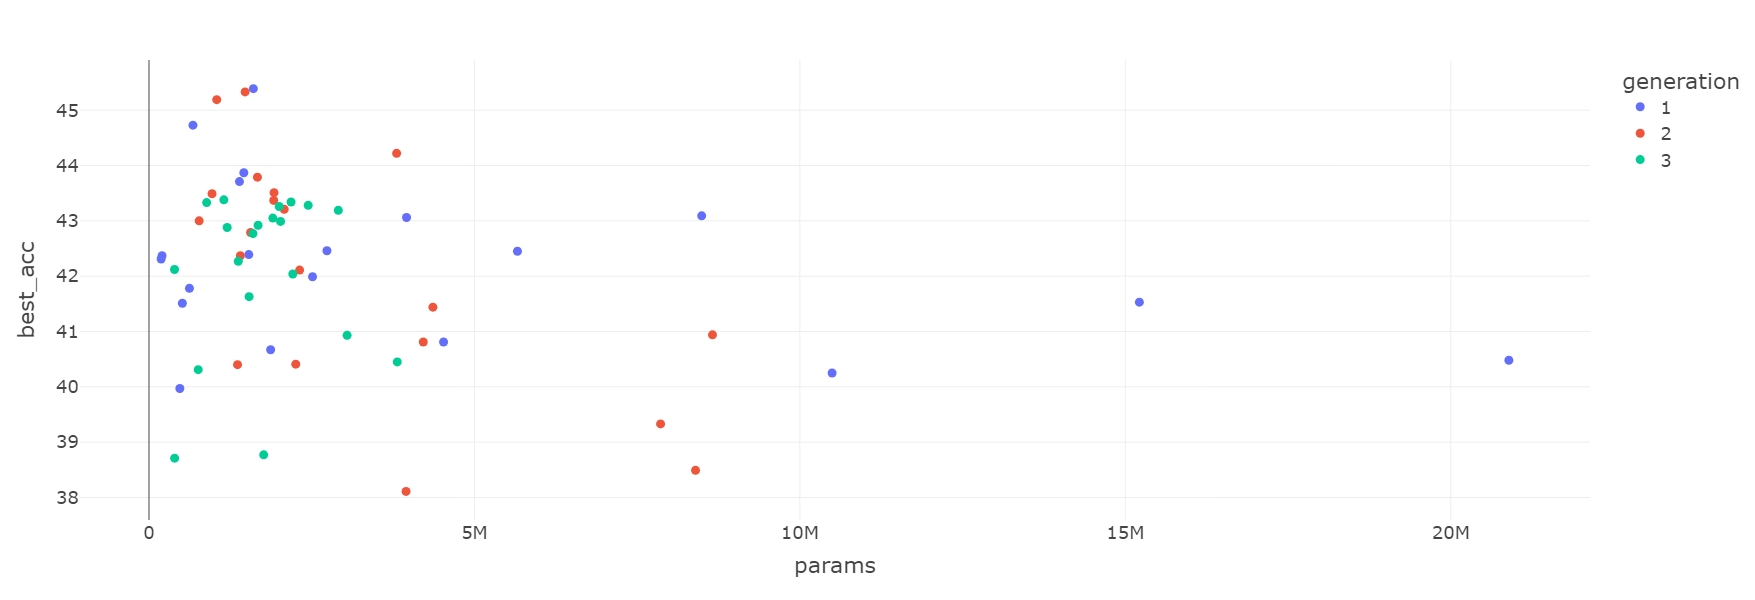

In [92]:
# Evonas CifarTile
scatter_results(df, "params","best_acc")

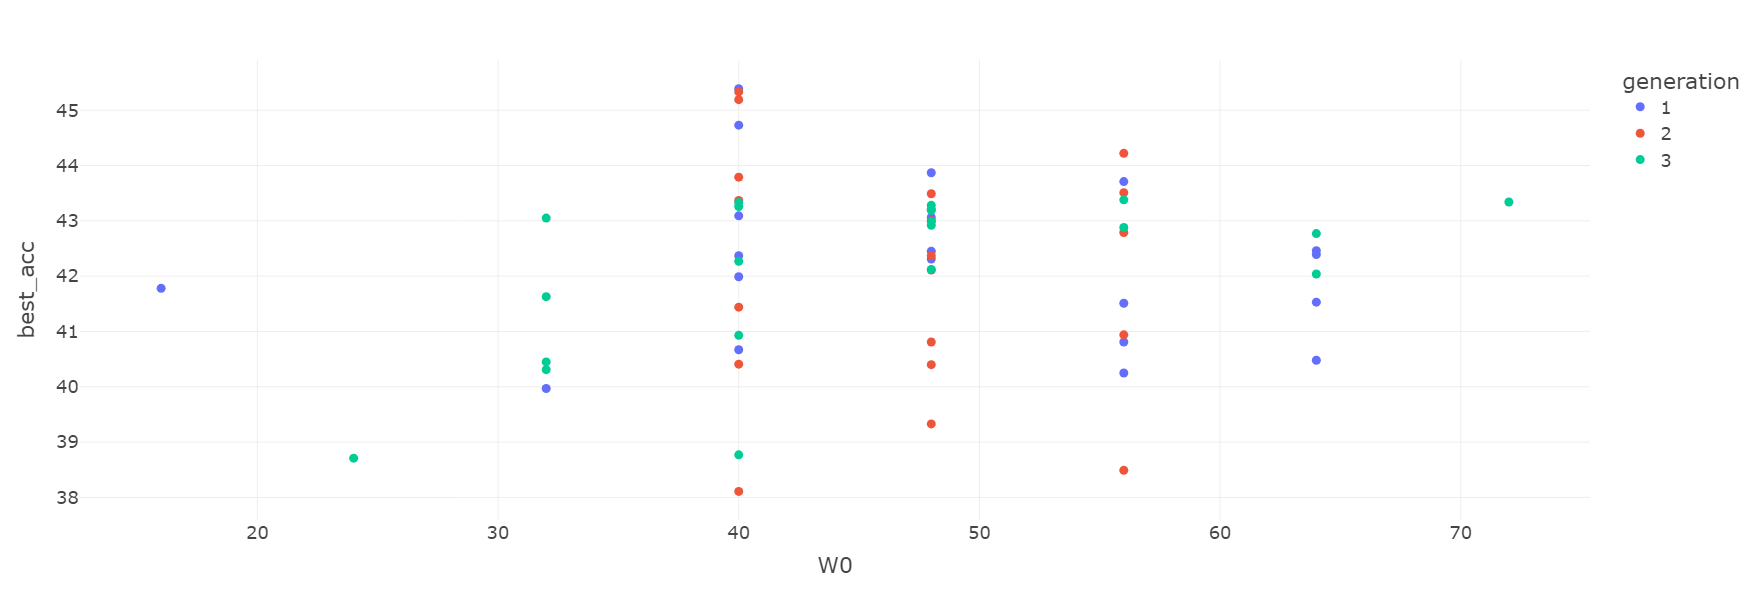

In [97]:
# Evonas CifarTile
scatter_results(df, "W0","best_acc")

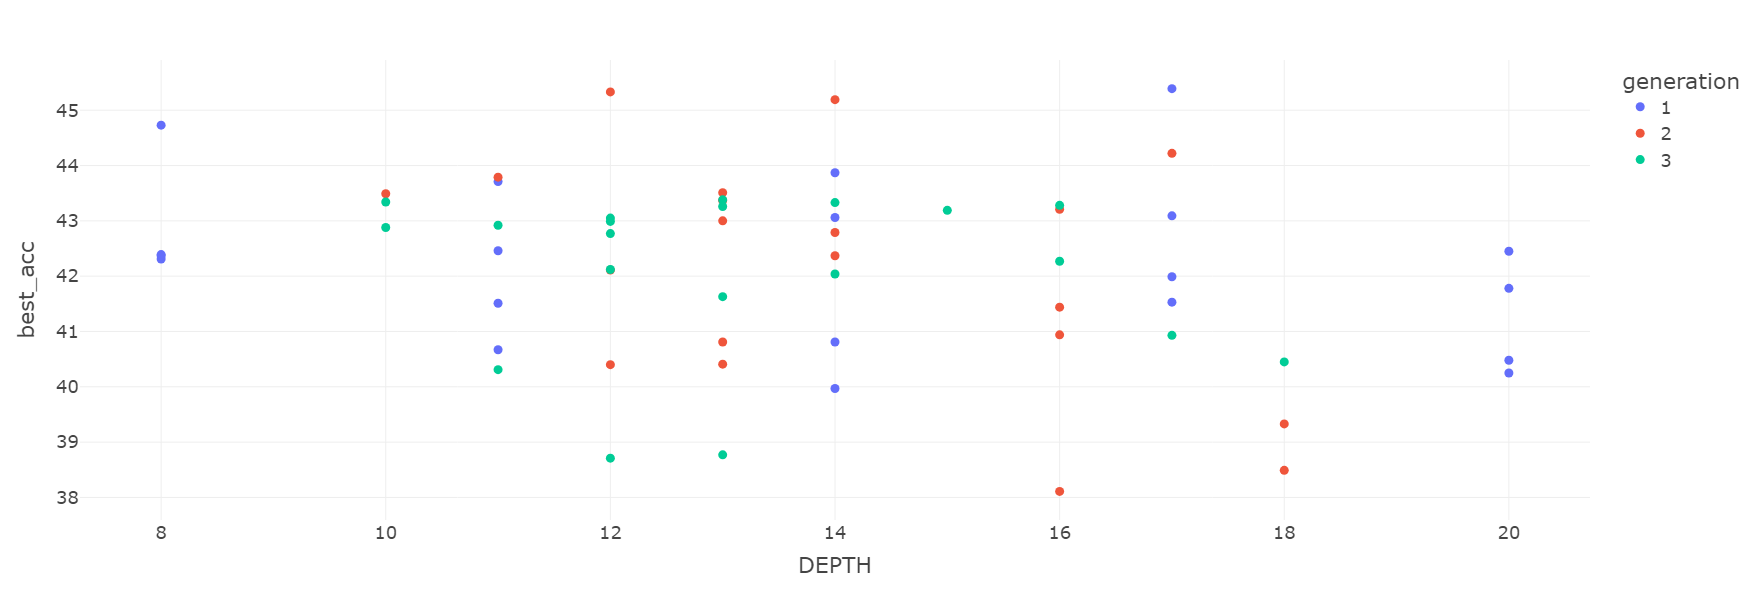

In [98]:
# Evonas CifarTile
scatter_results(df, "DEPTH","best_acc")

In [2]:

metadata={'num_classes': 4,
 'input_shape': [49260, 3, 64, 64],
 'codename': 'Caitie',
 'benchmark': 47.008,
 'rand_augment': False}
regnet_space=RegNet(metadata,
                    W0=[16, 96, 8],
                    WA=[16, 64, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,25,1], 
                    G=[8,8,8], 
                    base_config="../configs/search_space/config.yaml")

In [5]:
WA,W0,WM,D,W=[float(16),int(32),float(2.5),int(12), int(8)]
model, info=regnet_space.create_model(params=[WA,W0,WM,D,W], save_folder=None, name=None, gen=None, config_updates=None)

res_bottleneck_block
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'bot_mul': 1.0, 'group_w': 8, 'se_r': 0.25, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
{'stem_type': 'res_stem_cifar', 'stem_w': 64, 'input_channels': 8, 'block_type': 'res_bottleneck_block', 'depths': [2, 4, 6], 'widths': [32, 80, 200], 'strides': [2, 2, 2], 'bot_muls': [1.0, 1.0, 1.0], 'group_ws': [8, 8, 8], 'head_w': 0, 'se_r': 0.25, 'num_classes': 4, 'downsample': 'avg', 'drop_path_rate': 0.01, 'dropout_rate': 0.1}
res_bottleneck_block


In [6]:
from torchsummary import summary

In [7]:
info

{'ws': [32, 80, 200],
 'bs': [1.0, 1.0, 1.0],
 'gs': [8, 8, 8],
 'ds': [2, 4, 6],
 'num_stages': 3,
 'total_size_mb': 2.9799118041992188,
 'h': 1,
 'w': 1,
 'flops': 123166,
 'params': 778286,
 'acts': 1950,
 'WA': 16.0,
 'W0': 32,
 'WM': 2.5,
 'DEPTH': 12,
 'GROUP_W': 8}

In [15]:
summary(model, (8,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           4,608
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
      ResStemCifar-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           2,048
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 32, 32]           2,304
       BatchNorm2d-9           [-1, 32, 32, 32]              64
             ReLU-10           [-1, 32, 32, 32]               0
AdaptiveAvgPool2d-11             [-1, 32, 1, 1]               0
           Conv2d-12             [-1, 16, 1, 1]             528
             ReLU-13             [-1, 16, 1, 1]               0
           Conv2d-14             [-1, 3